Team members and primary contributions:
- Aadi Kothari (aadi@mit.edu): RRT/RRT* and helping code/run MIP
- Anup Sreekumar (anupsk@mit.edu): Mixed Integer Programming
- Tom Stuart (trstuart@mit.edu): Fault diagnoses

Note: Due to collective nature of the problem, teammates have worked together on some aspects of each subgroup.

Note: you may need to install the following packages to run this notebook:

1. Shapely -- see https://pypi.org/project/Shapely/ for installation instructions.
2. Descartes -- see https://docs.descarteslabs.com/installation.html for installation instructions.
3. Pulp -- see https://pypi.org/project/PuLP/ for installation instructions
4. Matplotlib -- see https://pypi.org/project/matplotlib/ for installation instructions
5. Time -- see https://pypi.org/project/python-time/ for installation instructions
6. Copy -- see https://docs.python.org/3/library/copy.html for installation instructions
7. Itertools -- see https://pypi.org/project/more-itertools/ for installation instructions

In [34]:
# Useful imports
from __future__ import division
%load_ext autoreload
%autoreload 2
%matplotlib inline
import yaml
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from shapely.geometry import Point, Polygon, LineString, box
from environment import Environment, plot_environment, plot_line, plot_poly, random_environment
import random as random

# Aerial Delivery and Research Support

## **The Problem** 

You lead the operations team for a group of researchers operating at remote locations throughout the Denali Wilderness. From your base camp in Denali National Park, you are responsible for delivering food, medical supplies, and equipment to the research teams located at 4 different locations throughout the wilderness--they endeavor to work at these locations throughout the summer. You are also responsible for supporting their research requirements to include maintenance of scientific equipment.

*Add in some cool pictures*

The terrain in Denali is extremely rugged and consists of a mix of taiga forests, high tundra, glaciers, and mountains. The research teams operate in locations unreachable by road and the scientists get in place by hiking in and out of their working locations. Currently supplies are delivered in the same way. This makes maintaining a continuous research presence extremely difficult as weather events, unexpected supply shortages, and other operational issues often lead to dangerously low provisions at the research sites--forcing the scientists to return intermittently to ensure the safety of the team.

Fortunately your team has just come into possession of 7 drones who are capable of delivering supplies to the teams. Your task is to:

<ol>
    <li><b> Plan routes between all sites and the base camp avoiding designated no-fly areas.</b></li>
    <li><b> Develop a supply delivery schedule based upon your planned routes, your drone delivery capabilities, and research team needs.</b></li>
    <li><b> Develop a method to diagnose scientific equipment faults and issues to determine when equipment supplies need to be delivered to a team.<b/></li>
</ol>

## **Route Planning with RRT and RRT*** 

Your drones can overfly most of terrain between you and the research teams but must take care to avoid areas designated noise sensitive due to wildlife, ecologically sensitive areas where it is deemed completely unnacceptable for a drone to crash, and campsites in the national park near your launch location. All of these areas were designated no-fly areas by the Bureau of Land Management and the National Park Service. Finally, some high altitude areas cannot be overflown due to drone performance limitations.

Your team has developed a map depicting these no-fly areas, your base camp, and the research sites. Anything outside the map boundaries is also considered a no-fly area. Based on the ecological sensitivity of Denali (and the importance that the National Park Service puts on keeping the wilderness as pristine as possible!) there are <ins> a lot </ins> of no-fly areas. Your drones can be relied upon to stay within 100 meters of any planned path (this navigation error will be exceeded with a probability of 10<sup>-5</sup> in any given flight-hour so it's acceptable use this number for path planning!).

Due to the high latitude of your operations, your team uses a grid system to specify camp locations referenced to True North. For the remote camps, you are provided with a landing zone (LZ) geometry. Each unit digit on the grid system represents one kilometer. Hence, location (-4,-2) is one kilometer *true* south of position (-3,-2).

Based on this grid system, the relevant locations are:

<ul class="dashed">
  <li>The base camp drone launch site is located at position (0,0)</li>
  <li>The site 1 LZ bounds are (4.1,4.1), (3.7,4.1), (3.7,3.7),(4.1,3.7).</li>
  <li>The site 2 LZ bounds are (9.7,0), (9.7,0.4), (10,0.4),(10,0).</li>
  <li>The site 3 LZ bounds are (6,0), (5.6,0), (5.6,-0.2),(6,-0.2).</li>
  <li>The site 4 LZ bounds are (-2,6), (-2,6.4), (-1.6,6.4),(-1.6,6).</li>
</ul>

**The code block below shows the map of the no-fly areas (in blue), the base camp (in magenta), and the LZs (in green).**

C:\Users\Aadi\PADM_project_submission1\environment.py:138: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  polygon.name = name
C:\Users\Aadi\Anaconda3\lib\site-packages\descartes\patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


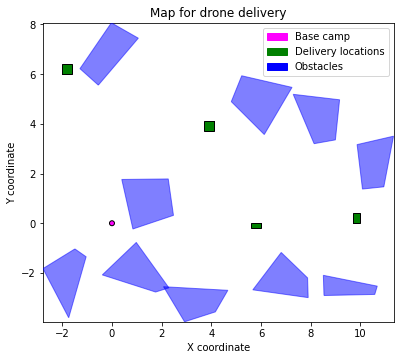

In [35]:
# Plot the environment 
env = Environment('simple.yaml')
ax = plot_environment(env)

# Base camp location
radius = 0.1
start_pose = (0,0)
start_poly = Polygon([(start_pose[0],start_pose[1]), (start_pose[0]-0.4,start_pose[1]), (start_pose[0]-0.4,start_pose[1]+0.4),(start_pose[0]+0.4,start_pose[1]+0.4)])
start_point = Point(start_pose[0],start_pose[1])
start_ball = start_point.buffer(radius)

# Camp locations
LZ1 = Polygon([(4.1,4.1), (3.7,4.1), (3.7,3.7),(4.1,3.7)])
LZ2 = Polygon([(9.7,0), (9.7,0.4), (10,0.4),(10,0)])
LZ3 = Polygon([(6,0), (5.6,0), (5.6,-0.2),(6,-0.2)])
LZ4 = Polygon([(-2,6), (-2,6.4), (-1.6,6.4),(-1.6,6)])

LZs = (LZ1, LZ2, LZ3, LZ4)
loc_coord = [start_pose, ((4.1+3.7)/2, (4.1+3.7)/2), ((9.7+10)/2, (0+0.4)/2), ((6+5.6)/2, (0-0.2)/2), ((-2-1.6)/2, (6+6.4)/2)]
loc_poly = [start_poly, LZ1, LZ2, LZ3, LZ4]

loc_name = ["Base Camp", "Delivery Location 1", "Delivery Location 2", "Delivery Location 3", "Delivery Location 4"]
# Plot base camp in magenta
plot_poly(ax, start_ball,'magenta')
# Plot research camps in green
for LZ in LZs:
    plot_poly(ax, LZ,'green')
plt.xlabel("X coordinate");
plt.ylabel("Y coordinate");
plt.title("Map for drone delivery")
magenta_patch = patches.Patch(color='magenta', label='Base camp')
green_patch = patches.Patch(color='green', label='Delivery locations')
blue_patch = patches.Patch(color='blue', label='Obstacles')
ax.legend(handles=[magenta_patch, green_patch, blue_patch]);

<ins>**Rapidly Exploring Random Trees (RRT)**</ins>

Looking at the map, you are a bit baffled in how you can make sure you find the best routes through this maze. Fortunately, you took 16.413 at MIT and recall learning about sampling-based planning methods--in particular Rapidly Exploring Random Trees (RRT). You decide to first tackle this problem with RRT. We chose RRT over graph search primarily due to the curse of dimensionality as highlighted in the course. For a better path, we would like to discretize our map further which exponentially increases the node size in case of a graph search algoithm. Further, we can also incoporate our agent's dynamics using RRT since we simulate forward (much harder to implement in probabilistic roadmap planning).

**Academic description of RRT**
In RRT (Rapidly Exploring Random Trees), the search tree is incrementally generated using samples from search space in a random fashion. In the iterative process:
<li> A random coordinate is chosen in free space </li>
<li> Find the nearest vertex exisiting in the tree to that coordinate</li>
<li> Steer that vertex in the direction of the coordinate by a depth d</li>
<li> If the new vertex is obstacle free, add it to our tree.</li>
<li> Repeat the above steps until the vertex lands in the goal region</li>
RRT is probabilistically complete which means that it will find a solution in case the solution exists (though it may take a long time to run). A few downsides of RRT are that it usually returns a suboptimal path and also fails to check if a path does not exist (i.e. the algorithm will run forever in case the path between start and goal location does not exist).

**RRT Demo going from Base Camp --> LZ1, discuss how non-optimal**

Taking a look at the produced route, you can tell by inspection that the route is clearly not optimal. Thankfully, you remember that there is an optimal version of RRT, RRT* that you should be able to implement for this problem.

<b> Academic description of RRT* </b>
RRT* is an optimized version of RRT, and is asymptotically optimal. In an ideal case when number of nodes tend to infinity, RRT* yields the shortest path (optimal path) to the goal by keeping track of the distance each vertex has travelled relative to the parent vertex. Another variation is that after a vertex is added to the lowest cost neighbor, the tree is rewired to the new vertex in order to decrease individual cost. In the the iterative process:
<li> A random coordinate is chosen in free space that is not in any obstacle</li>
<li> Find the nearest node existing in the tree to that coordinate</li>
<li> Store the cost i.e. the distance between the nearest node to the coordinate </li>
<li> Examine neighbors within a specified radius of the new node and updates costs for them if combined cost with the new node turns out to be less than the existing cost of that neighbor.</li>
<li> Update parent of that graph and the node accordingly.</li>
<li> Repeat the above steps until the vertex lands in the goal region</li>
Note: Instead of the above terminating condition, we can run the code for more iterations to find a better (more optimal) path. Also, if we have the agent dynamics, we can find the "nearest node" that is closest to the possible achievable states of the agent.

<ins>**Motion planning solution summarazied**</ins>
**Input** : The map of the delivery region and the coordinates of the basecamp and the five destinations <br>
**Output** : The distance matrix between basecamp and destinations <br>
**Method** : Run RRT/RRT* among all points (basecamp and destinations) and populate with the shortest distance <br>

In [23]:
# Define the maps containing start and goal nodes along with obstacles
# Plot the environment 
env = Environment('simple.yaml')
ax = plot_environment(env)

# Base camp location
radius = 0.1
start_pose = (0,0)
start_poly = Polygon([(start_pose[0],start_pose[1]), (start_pose[0]-0.4,start_pose[1]), (start_pose[0]-0.4,start_pose[1]+0.4),(start_pose[0]+0.4,start_pose[1]+0.4)])
start_point = Point(start_pose[0],start_pose[1])
start_ball = start_point.buffer(radius)

# Camp locations
LZ1 = Polygon([(4.1,4.1), (3.7,4.1), (3.7,3.7),(4.1,3.7)])
LZ2 = Polygon([(9.7,0), (9.7,0.4), (10,0.4),(10,0)])
LZ3 = Polygon([(6,0), (5.6,0), (5.6,-0.2),(6,-0.2)])
LZ4 = Polygon([(-2,6), (-2,6.4), (-1.6,6.4),(-1.6,6)])

LZs = (LZ1, LZ2, LZ3, LZ4)

# Camp coordinates
loc_coord = [start_pose, ((4.1+3.7)/2, (4.1+3.7)/2), ((9.7+10)/2, (0+0.4)/2), ((6+5.6)/2, (0-0.2)/2), ((-2-1.6)/2, (6+6.4)/2)]
loc_poly = [start_poly, LZ1, LZ2, LZ3, LZ4]

# Plot base camp in magenta
plot_poly(ax, start_ball,'magenta')

# Plot research camps in green
for LZ in LZs:
    plot_poly(ax, LZ,'green')
    
plt.xlabel("X coordinate");
plt.ylabel("Y coordinate");
plt.title("Map for drone delivery")
magenta_patch = patches.Patch(color='magenta', label='Base camp')
green_patch = patches.Patch(color='green', label='Delivery locations')
blue_patch = patches.Patch(color='blue', label='Obstacles')
ax.legend(handles=[magenta_patch, green_patch, blue_patch]);

In [10]:
#RRT Implementation:

import pdb
from utils import *
from graph import Graph, Edge
from search_classes import SearchNode, Path

def rrt(bounds, environment, start_pose, radius, end_region, start_ind, end_ind):
    '''
    bounds: Defines bounds of the given environment
    environment: Generate environment from .yaml file
    start_pose: starting position expressed as a tuple of (x,y) coordinate
    end_region: polygon of the end region
    start_ind: index of start pose
    end_ind: index of end postion
    '''
    counter = 0
    d = 0.2 # steer distance 
    graph = Graph()
    graph.add_node(start_pose)
    
    # Draw the environment (with its obstacles)
    ax = plot_environment(environment, bounds)
    
    # Draw the start and end poses
    plot_poly(ax, Point(start_pose).buffer(radius, resolution=3),'magenta')
    plot_poly(ax, end_region,'brown', alpha=0.2)
    
    while True:
        Xrand = (np.random.uniform(bounds[0], bounds[2]), np.random.uniform(bounds[1], bounds[3]))
        
        # Collision check
        if collision_point(Point(Xrand), environment):
            continue
        
        # Find nearest node to the random node
        Xnearest = Nearest(graph, Xrand)
        
        # Steer nearest node towrads random node by a distance d
        Xnew = Steer(Xnearest, Xrand, d)
        
        line = LineString([Xnearest, Xnew])
        expanded_line = line.buffer(radius, resolution=3)
        
        # Add and plot node, edge if there is no collision
        if not collision_line(expanded_line, environment):
            plot_line(ax, line)
            graph.add_node(Xnew)
            graph.add_edge(Xnew, Xnearest, 1, False)
            
        # Check if end region contains new node
        if end_region.contains(Point(Xnew)):
            break
    # Store goal node
    Xgoal = Xnew
    path = [Xnew]
    
    # Loop to iterate through edges to find the solution path
    while True:
        edges = graph._edges[Xnew]
        if len(edges) == 1:
            Xprev = list(edges)[0].target
            path.insert(0, Xprev)
            Xnew = list(edges)[0].target
        if Xnew == start_pose:
            break
    path_len = 0
    
    # Find path length and plot final path
    for ind in range(len(path) - 1):
        line = LineString([path[ind], path[ind+1]])
        expanded_line = line.buffer(radius, resolution=3)
        plot_poly(ax, expanded_line, 'green', alpha=0.1)
        x,y = path[ind]
        xnxt, ynxt  = path[ind+1]
        path_len += np.sqrt((x - xnxt)**2 + (y - ynxt)**2)
    plot_poly(ax, end_region,'green')
    # Plot details
    plt.title("Path from %s to %s\nNumber of nodes in the tree %i . Number of nodes in the path %i. Path length %f" \
              %(loc_name[start_ind],loc_name[end_ind],len(graph._nodes), len(path), path_len))
    plt.xlabel("X coordinate");
    plt.ylabel("Y coordinate");

    magenta_patch = patches.Patch(color='magenta', label='Start node')
    green_patch = patches.Patch(color='green', label='Goal position')
    blue_patch = patches.Patch(color='blue', label='Obstacles')
    ax.legend(loc = "upper right", handles=[magenta_patch, green_patch, blue_patch]);
    return (path, path_len)

# Steer nearest node toward random node by distance d
def Steer(Xnearest, Xrand, d):
    '''
    Xnearest: nearest node
    Xrand: random sampled node
    d: steer distance d
    '''
    dirn = np.array(Xrand) - np.array(Xnearest)
    length = np.linalg.norm(dirn)
    dirn = (dirn / length) * min (d, length)

    Xnew = (Xnearest[0]+dirn[0], Xnearest[1]+dirn[1])
    return Xnew

# Find nearest node to the random node
def Nearest(graph, Xrand):
    '''
    graph: Graph used for the nodes and edges
    Xrand: random node
    '''
    min_dist = np.inf
    nearest_node = ()
    for node in graph._nodes:
        euc_dist = np.sqrt((node[0] - Xrand[0])**2 + (node[1] - Xrand[1])**2)
        if euc_dist < min_dist:
            min_dist = euc_dist
            nearest_node = node
    return nearest_node

# Collision check for line
def collision_line(expanded_line, env):
    for i, obs in enumerate(env.obstacles):
        # Check collisions between the expanded line and each obstacle
        if expanded_line.intersects(obs):
            return True
    return False

# Collision check for point
def collision_point(point, env):
    for i, obs in enumerate(env.obstacles):
        # Check if point is inside obstacle
        if obs.contains(point):
            return True
    return False


The code below runs through all the possible combinations for the deliveries between the basecamp and delivery locations. A distance matrix is then populated with indices coresponding to delivery locations. This matrix is further used in our linear programming problem for finding optimal sequence of deliveries.

The paths and graphs generated by the RRT algorithm for each possible combination is then plotted and description of the path lengths, number of nodes expanded, etc. is depicted. 

Generating path from Base Camp to Delivery Location 1


C:\Users\Aadi\Anaconda3\lib\site-packages\descartes\patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


Generating path from Base Camp to Delivery Location 2
Generating path from Base Camp to Delivery Location 3
Generating path from Base Camp to Delivery Location 4
Generating path from Delivery Location 1 to Delivery Location 2
Generating path from Delivery Location 1 to Delivery Location 3
Generating path from Delivery Location 1 to Delivery Location 4
Generating path from Delivery Location 2 to Delivery Location 3
Generating path from Delivery Location 2 to Delivery Location 4
Generating path from Delivery Location 3 to Delivery Location 4
Distance matrix from RRT:
[[ 0.          7.6        15.6        13.50183251  9.61402539]
 [ 7.6         0.          9.6868244   6.02276801  7.37792284]
 [15.6         9.6868244   0.          7.21179612 15.4       ]
 [13.50183251  6.02276801  7.21179612  0.         11.29652092]
 [ 9.61402539  7.37792284 15.4        11.29652092  0.        ]]


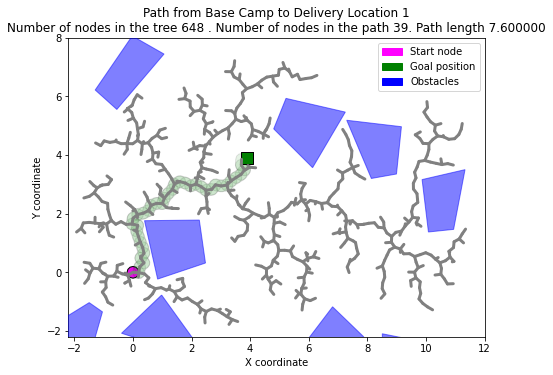

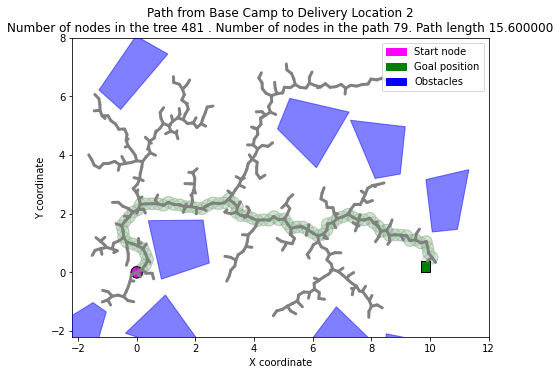

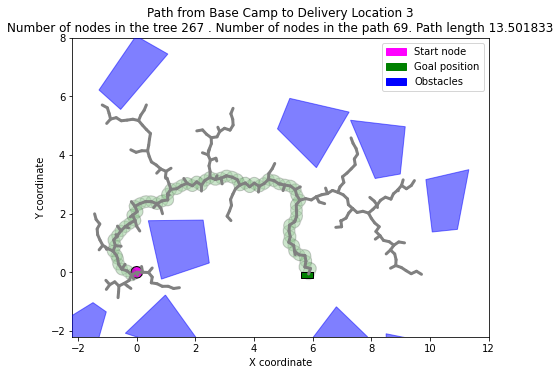

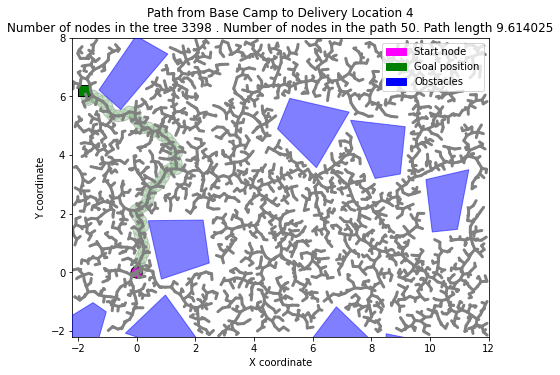

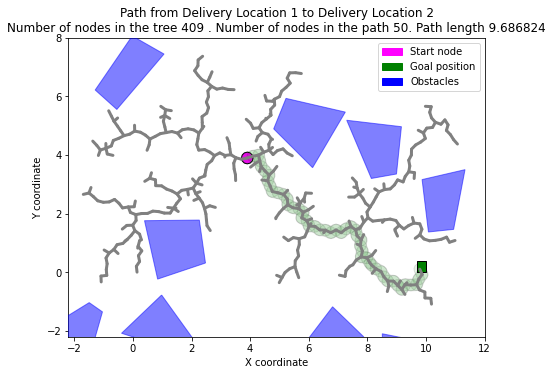

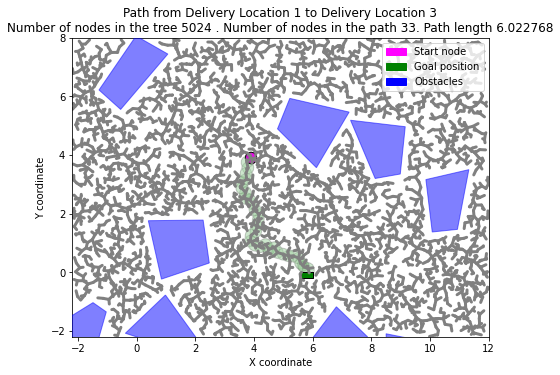

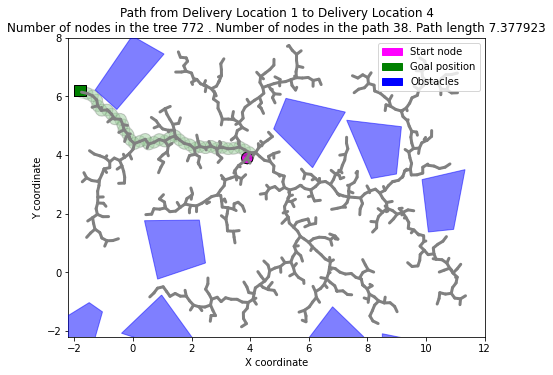

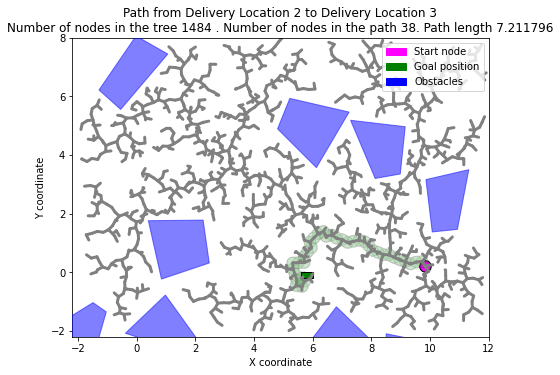

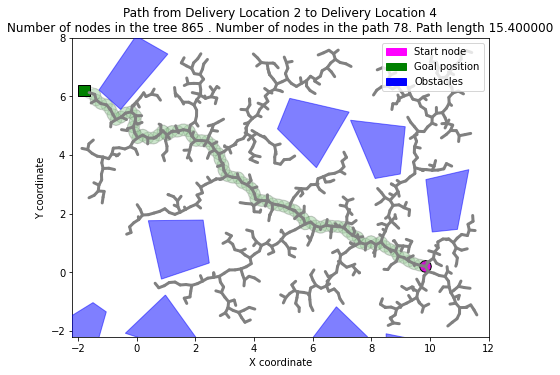

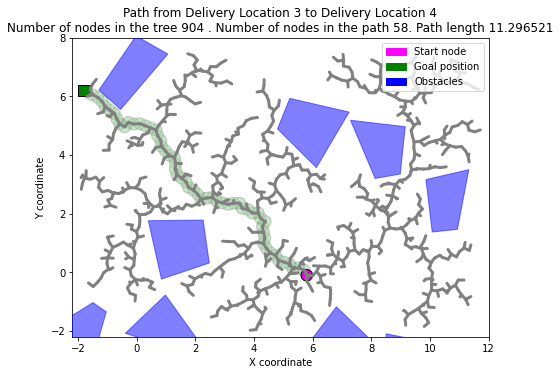

In [11]:
# Populate distance matrix using rrt
from shapely.geometry import Point, Polygon, LineString, box
radius = 0.2
bounds = (-2.2, -2.2, 12, 8)
distance_rrt = np.empty((5,5))

for ind1 in range(len(distance_rrt)):
    distance_rrt[ind1,ind1] = 0
    for ind2 in range(ind1+1, len(distance_rrt)):
        start = loc_coord[ind1]
        goal_region = loc_poly[ind2]
        print("Generating path from %s to %s" %(loc_name[ind1], loc_name[ind2]))
        path, path_len = rrt(bounds, env, start, radius, goal_region, ind1, ind2)
        distance_rrt[ind1][ind2] = path_len
        distance_rrt[ind2][ind1] = path_len
print("Distance matrix from RRT:")
print(distance_rrt)

From visual observation of the above plots, we can clearly see that the paths are not optimal. Using these paths and distance values for our drones will lead to higher costs, longer distances and will thus prove to be an inefficient approach. In order to solve this problem we implement an optimal version of RRT called RRT star. The code below shows the implmentation of RRT star:

In [104]:
# Use RRT/RRT* to calculate the optimal distance matrix coresponding to the distances between basecamp and destinations
import pdb
from utils import *
from graph import Graph, Edge
from search_classes import SearchNode, Path

def euc_distance(x, y):
    dist = np.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)
    return dist
def findNeighbors(graph, Xnew, rad, cost, start_pose, environment):
    Xneighbors = []
    Xbest = ()
    min_dist = np.inf
    for node in graph._nodes:
          
        dist_to_node = euc_distance(node, Xnew)
        if  dist_to_node <= rad:
            Xneighbors.append(node)
        
        if (path_cost(graph, start_pose, node) + dist_to_node) < min_dist: #if (dist_to_node + cost[node]) < min_dist:
            #line = LineString([Xnew, node])
            #expanded_line = line.buffer(radius, resolution=3)
            #if collision_line(expanded_line, environment):
            #    continue
            Xbest = node
            min_dist = path_cost(graph, start_pose, node) + dist_to_node#+ cost[node]
    return Xbest, Xneighbors
def Steer(Xnearest, Xrand, d):
    dirn = np.array(Xrand) - np.array(Xnearest)
    length = np.linalg.norm(dirn)
    dirn = (dirn / length) * min (d, length)

    Xnew = (Xnearest[0]+dirn[0], Xnearest[1]+dirn[1])
    return Xnew
def Nearest(graph, Xrand):
    min_dist = np.inf
    nearest_node = ()
    for node in graph._nodes:
        euc_dist = np.sqrt((node[0] - Xrand[0])**2 + (node[1] - Xrand[1])**2)
        if euc_dist < min_dist:
            min_dist = euc_dist
            nearest_node = node
    return nearest_node
def collision_line(expanded_line, env):
    for i, obs in enumerate(env.obstacles):
        # Check collisions between the expanded line and each obstacle
        if expanded_line.intersects(obs):
            return True
    return False
def collision_point(point, env):
    for i, obs in enumerate(env.obstacles):
        # Check if point is inside obstacle
        if obs.contains(point):
            return True
    return False
def path_cost(graph, x_init, x_new):
    path_dist = 0
    while not x_init == x_new:
        edges = graph._edges[x_new]
        path_dist += list(edges)[0].weight
        x_new = list(edges)[0].target
    return path_dist

In [1]:
def rrt_star(bounds, environment, start_pose, radius, end_region): 
    # Hyper parameters:
    
    line_plot_rad = 0.01
    iter = 10 # Iterations for rrt_star
    rad = 0.3 # RRT* radius lookup
    d = 0.25 # steer distance 
    
    graph = Graph()
    graph.add_node(start_pose)
    
    # Draw the environment (with its obstacles)
    ax = plot_environment(environment, bounds)
    # Draw the start and end poses
    plot_poly(ax, Point(start_pose).buffer(radius, resolution=3),'magenta')
    plot_poly(ax, end_region,'brown', alpha=0.2)
    
    cost = dict() # Stores cost of each node of the graph
    Xgoal = () # S\tore goal position node
    cost[start_pose] = 0
    flag = 0
    count = 0
    while True:
        Xrand = (np.random.uniform(bounds[0], bounds[2]), np.random.uniform(bounds[1], bounds[3]))
        if collision_point(Point(Xrand), environment):
            continue
        Xnearest = Nearest(graph, Xrand)
        Xnew = Steer(Xnearest, Xrand, d)
        dist = euc_distance(Xrand, Xnearest)
        if dist < d:
            Xnew = Xrand
            
        Xbest, Xneighbors = findNeighbors(graph, Xnew, rad, cost, start_pose, environment)
        if Xbest == ():
            continue
        # Collision check:
        line = LineString([Xnew, Xbest])
        expanded_line = line.buffer(radius, resolution=3)
        if collision_line(expanded_line, environment):
            continue  
        #plot_line(ax, line)
        
        # Find cost of new node and add it to the graph
        cost[Xnew] = euc_distance(Xbest, Xnew) + path_cost(graph, start_pose, Xbest) #+ cost[Xbest]
        graph.add_node(Xnew)
        graph.add_edge(Xnew, Xbest,  euc_distance(Xnew, Xbest), False)
        
        # Iterate through neighbors to rewire the tree
        for x_prime in Xneighbors:
            if (cost[Xnew] + euc_distance(Xnew, x_prime)) < cost[x_prime]:
                cost[x_prime] = cost[Xnew] + euc_distance(Xnew, x_prime)
                #Rewire the tree
                graph.delete_edge(x_prime)
                graph.add_edge(x_prime, Xnew, euc_distance(x_prime, Xnew), False)
        
        # While loop iteration play:
        count = count + 1
        if flag == 0:
            count = 0
        if count > iter:
            break
        if end_region.contains(Point(Xnew)) and flag ==0:
            Xgoal = Xnew
            flag = 1
            
    Xnew = Xgoal
    path = [Xnew]
    
    # Prtinting graph on the map
    for node in graph._edges.keys():
        for edge in graph._edges[node]:
            child = edge.target
            parent = edge.source
            line = LineString([child, parent])
            expanded_line = line.buffer(line_plot_rad, resolution=1)
            plot_poly(ax, expanded_line, 'black', alpha=0.5)
    
    # Extracting path of the solution
    while True:
        edges = graph._edges[Xnew]
        if len(edges) == 1:
            Xprev = list(edges)[0].target
            path.insert(0, Xprev)
            Xnew = list(edges)[0].target
        if Xnew == start_pose:
            break
    path_len = 0
    for ind in range(len(path) - 1):
        line = LineString([path[ind],path[ind+1]])
        expanded_line = line.buffer(radius, resolution=3)
        plot_poly(ax, expanded_line, 'green', alpha=0.75)
        x,y = path[ind]
        xnxt, ynxt  = path[ind+1]
        path_len += np.sqrt((x - xnxt)**2 + (y - ynxt)**2)
    plt.title("Number of nodes in the tree %i . Number of nodes in the path %i. Path length %f" %(len(graph._nodes), len(path), path_len))
    return (path, path_len)

Due to multiple path collision checks as well as rewiring of the tree in RRT star, the below code takes a while to run and populate distance matrix. To save the reader's rime, we have included results of when the code is run for a sufficiently long period of time.

In [ ]:
from shapely.geometry import Point, Polygon, LineString, box
radius = 0.2
bounds = (-2.2, -2.2, 12, 8)
distance_rrt_star = np.empty((5,5))
#path,path_len = rrt_star(bounds, env, start_pose, radius, LZ4)
for ind1 in range(len(distance_rrt_star)):
    distance_rrt_star[ind1,ind1] = 0
    for ind2 in range(ind1+1, len(distance_rrt_star)):
        print("Generating path from %s to %s" %(loc_name[ind1], loc_name[ind2]))
        start = loc_coord[ind1]
        goal_region = loc_poly[ind2]
        path, path_len = rrt_star(bounds, env, start, radius, goal_region)
        distance_rrt_star[ind1][ind2] = path_len
        distance_rrt_star[ind2][ind1] = path_len
print("RRT star distance matrix:")
print(distance_rrt_star)

![title](Distance_matrix.jpg)
![title](Plot1.jpg)
![title](Plot2.jpg)
![title](Plot3.jpg)
![title](Plot4.jpg)

From the above plots, we can clearly see that the paths generated are optimal. In fact, we can also notice the general nature of RRT* to generate straight paths in the  graph. The distance matrix generated is now stored and used for the mixed integer programming problem as shown below.

# **Mixed Integer Programming to determine Drone Routing & Drop Point Assignemnt to each drone**

Through the RRT/RRT* module we will populate shortest path from basecamp to each drop points and from each drop point to every other drop point. The output will be a 5x5 matrix with [0,0] representing the basecamp and the other pair representing the distances. <br>
<br>Once this data is populated, we used a MIP (linear) model to determine the following objectives : <br>
1. How many drones and which tye of drone to be used<br>
2. The route to be taken by each drone with drop point assignment in the route<br>
3. The percentage of the load of drop point to be taken by each drone (if a drop point is serviced by multiple drones)<br>

The overall model - Objective function, Parameters, and Constraints - is explained below both in mathematical formulations and in python code. 

## **A. Concept Introduction** <br>
MIP is a method employed to maximize or minimize an objective function (represented by a mathemetical equation) against constraints which are also represented in mathematical formulation. In our model we are using linear relationships between variables both in the objective fucntion and in the cosntratins. <br>

The three major components of a MIP is 
<br><br>
(i) Objective function : What the model should maximize or minimize . This is usually modelled mathematically using the decision variables and constants. Refer Mathematical model, in which we explain how we are defining the obejctive fucntion for our model . 
<br>
(ii) Decision Variables : These are the variables that the MIP model optimizes ( or iterates with ) to achieve the objective function <br>
(iii) Constraints : These are the relationships or bounds for the decision variables that the model needs to ensure is within the limits . For our models, these relations are modelled in linear relationship. 
<br><br>
The standrad form of a MIP is shown below <br>
Reference : https://www.gurobi.com/resource/mip-basics/ <br>
<br>
Find a vector  **X**        <-- Decision Variable <br>
that maximizes $  C^T X $   <-- Objective Functiobn <br>
subject to     $ AX = B $  <-- Linear constraints  <br>
and            $ L <= X <= U $   <-- L,U are upper and lower Bound constraints <br>
and            Some or all X will take integer values


## **B. MIP Mathematical Model for Aerial delivery system**
### **1. Data Set used in the model** : 
1. N_drops: Number of drop points ( 4 drop point and 1 basecamp) 
2. N_drones : Number of drones in system ( 3 ) 
3. N_property : Property of demand and drones ( as Weight (Kgs) and Volume ( Meter cube ~ $m^3$ )
4. N_trips : Number of trips by the drone ( Maximum is set to 5 ) 
   Trip is a truck round route from basecamp to drop points and back to warehouse

### **2. Indexes used in the model** :
1. i,j,h refers to set drop points from 1 to N_drops ( i=j=h= 0 warehouse )
2. t refers to set drones from 1 to N_drones
3. d in set trips from 1 to N_trips
4. p in property from 1 to N_property
(Note: In python implemenataion the start for index is 0 and ends at N-1)

### **3. Parameters or Input to the Program** : <br>
1. Distance matrix between each point to every other point from RRT/RRT* <br>
    Represented as $D_{ij}$ (i=j=0 refers to the basecamp)<br>
    (The distance $D_{ij}$ is kept to very huge along the diagnol . Please refer special notes under constraints )<br><br>
2. Fixed cost of using the drone in USD / Trip  <br>
    Representated as $FCT$
    This represents the investment costs, or rental or lease costs.<br> 
    (Refer the values in the python code section. The values have been taken from https://filmora.wondershare.com/drones/top-heavy-lift-drones.html )<br><br>
3. Variable cost of using the drone in USD/ Km for each Trip <br>
    Represented as $VC_t$<br>
    This represents the cost of maintaining the drone, the charging costs and distance related costs<br>
    (Refer the values in the python code section. The values have been taken from https://filmora.wondershare.com/drones/top-heavy-lift-drones.html )<br><br>
4. Averge speed of the drone in km/hr <br>
    Represented as $S_t$<br>
    We are assuming Speed to be 50 Kmph <br><br>
5. Demand of each drop point in terms of weight (tons) and volume (cubic meter)<br>
    Represented as $Demand_{ip}$<br>
    We have made assumptions for each drop point in terms of weight (tons) and volume (cubic meter)<br><br>
6. Capacity of drone in terms of weight (tons) and volume (cubic meter)<br>
    Represented as $Capacity_{tp}$<br>
    We took reference on current drone capability in terms of weight (tons) and volume (cubic meter)<br><br>
7. Eficiency of drone could be used ( % of weight or volume capacity could be used to transport)<br>
    Represented as $Eff$<br>
    Represented as Percentage(%)<br><br>
8. Max Range that a drone could travel ( in Kms )<br>
    Represented as $maxRange$<br>
    This is derived from the average speed (km per hour) and time limits.<br>
    The values have been taken from https://filmora.wondershare.com/drones/top-heavy-lift-drones.html )<br><br>
<br>
(All the values for these variables can be seen in  python code)

### **5. Objective function** :
The objective function is to **Minimize the total cost of delivery of supplies**. <br><br> 
Out intention is to have 2 components to total cost. <br>

Fixed cost : Fixed cost of using the drone (Investment cost or Lease/rental charges defined as USD per trip for each drone) <br>
    Fixed costs (FC) = $ \sum\limits_{d=1}^{NTrips}\sum\limits_{t=1}^{Ndrones} ( Y_{dt} * FCT )  $

Then we modelled the Total cost as : <br>
    
    Total Costs = Minimize 

$ (\sum\limits_{i=1}^{NDrops}\sum\limits_{j=1}^{NDrops}\sum\limits_{d=1}^{NTrips}\sum\limits_{t=1}^{Ndrones}
        Z_{ijdt} * D_{ij} * VC_t )  + FC$
<br> (Note that the last term FC is outside the first summaton group)

### **6. Constraints to the model** :
<br>    
0. Constraint 0  :<br><br>
    We do not want any movement from i to j, if i == j . These $X_{ijdt}$ should be forced to be 0 across all d and t <br>
    $X_{ijdt}$ = 0 $\forall d,t$ and $\forall i==j$
<br><br>   
1. Constraint 1 :<br><br>
    We want $Y_{dt}$ to be 1 , if the drone t is used in trip t and this depends on $X_{ijdt}$.
    If $X_{ijdt}$ >0 for a patricular drone t in trip t, then the corresponding $Y_{dt}$ <br>
    This is modelled as below : <br><br>
    $Y_{dt}$ >= $X_{ijdt}$ $\forall i,j,d,t$
 
    Note that if is $X_{ijdt}$ = 0, then the objective function will force $Y_{dt}$ to be 0 
<br><br> 
2. Constraint 2 :<br><br>
    We want $Z_{ijdt}$ to be 1, if any $X_{ijdt}$ is greater than 0 .<br>
    If $X_{ijdt}$ >0 for a patricular drone t in trip t, then the corresponding $Z_{ijdt}$ to be 1<br>
    Similar to constraint 1, if $X_{ijdt}$ = 0, the minimizing objective function forces $Z_{ijdt}$ to be 0<br>
    This is modelled as below : <br><br>
    $Z_{ijdt}$ >= $X_{ijdt}$ $\forall i,j,d,t$   
<br><br>    
3. Constraint 3 :<br><br> 
    We want all demand of each drop point to be >= 1 (Percentage >= 100) any of drones t in any of the drones t.<br>
    This is modelled as below : <br><br>
    $\sum\limits_{j=1}^{NDrops}\sum\limits_{d=1}^{NTrips}\sum\limits_{t=1}^{Ndrones} X_{ijdt} \geq$ 1 $\forall i  $
<br><br>     
4. Constraint 4 :<br><br> 
    The total load carried by the drone is less than the ton and volume capacity of drone t in all trips d.<br>
    We multiply the capacities of the drone d , with an "Eff" factor to factor in whether we can use the full capacuty or some portion of it ( eg 95% ) <br>
    This is modelled as below : <br><br>
    $\sum\limits_{i=1}^{NDrops} ( \sum\limits_{j=1}^{NDrops} X_{ijdt} * Demand_{ip} ) \leq$ $ Eff * Capacity_{tp} \forall d,t,p  $
<br><br>    
5. Constraint 5 :<br><br>
    We need to ensure that the drone does not fly beyond its rated range (in Kms) for the entire trip d for all drones d<br>
    This is modelled as below : <br><br>
    $\sum\limits_{i=1}^{NDrops}\sum\limits_{j=1}^{NDrops}\sum\limits_{d=1}^{NTrips} Z_{ijdt} * D_{ij} \leq maxRange_t$ $\forall t $
<br><br>     
6. Constraint 6 : <br><br>
    Sub Tour Eimination:<br> 
    A sub tour is a anormality that occurs in the transporatiaton problem <br> 
    Let us assume there is 1 basecamp (P) and 4 Suppliers (A,B,C,D) <br>
    Sub tour is a condition in which the drone will start from B go to C and then go back to C<br>
    We always want the drone to start from P and come back to P <br> 
    To ensure this we need to add an additional variable $R_{idt}$ <br>
    We will first add the rank of P to be 1 for all t and d. <br>
    The next supplier in the route will be assigned a rank higher than 1. <br>
    The idea is to give a rank to each supplier from where goods are picked up and ensure that no lower rank is picked up in the same trip ( not go back to same supplier ) and every new supplier to be picked up is given next higher rank. <br>
    Note: We need to use the Big M Method here to ignore this constraint when the $Z_{ijdt} = 0$. The big M is assigned N_drops<br>
    This is modelled as below in 2 lines : <br><br>
    (6.a) <br>
    $R_{idt} =1 $ $ \forall d,t$
    <br><br>
    (6.a) <br>
    $R_{jdt} \geq R_{jdt} + 1 - ( Ndrops * ( 1 - Z_{ijdt} ) ) $
    <br>
    The second term will become 0 if $Z_{ijdt}$ = 1, otherwise it does not matter what value $R_{jdt}$ takes when $Z_{ijdt}$ = 0
<br><br>     
7. Constraint 7 : <br><br>    
    As mentioned in costraint 6,we need to ensure that the drone leaves always from basecamp<br>
    This is modelled as below in 2 lines : <br><br>
    $\sum\limits_{i=1}^{NDrops} Z_{ijdt}$ = 1 $\forall$ $i=1,d,t$
<br><br>     
8. Constraint 8 : <br><br>    
    Balancing Constraints <br>
    We need to ensure that what comes into a drop point must leave from drop point also <br>
    This is only applicable to drop point and not the basecamp<br>
    This is modelled as below : <br><br>
    $\sum\limits_{i=1}^{NDrops} Z_{ihdt}$ = $\sum\limits_{j=1}^{NDrops} Z_{hjdt}$ $\forall$  $(i,j\geq2),d,t$
    
##### Special notes: 
1. In python implementation the start for index is 0 and ends at N-1
2. In the Distance i,j parameter data , the diagnol distance (between i and j when i == j is kept at arbitarily high. This is to avoid the $Z_{ijdt}$ from taking a value of 1 in that position.
3. The big M method used in constrain6 6 can be found here for a good explanation (http://www.universalteacherpublications.com/univ/ebooks/or/Ch3/mmethod.htm)


### **C. Python Code** 
#### **1. Packages used for Optimization**:

In [4]:
import numpy as np
from pulp import * # for optimization
import time
import copy

#### **2. Parameters, Dataset, Indexes used in the model** : 

In [5]:
#1. Distance matrix between each point to every other point from RRT/RRT* 
distance = [[0,419,310,25,49,26],
            [419,50000,592,445,483,413],
            [310,592,50000,335,358,288],
            [25,445,335,50000,30,51],
            [49,483,358,30,50000,75],
            [26,413,288,51,75,50000]] #50000 is done to minimize diagonola entries

#actual distance from RRT*
distance = [[ 0,6.0602571,10.10200439,6.18885202,6.53895829],
             [ 6.0602571,50000,7.09077131,4.42892364,6.15810891],
             [10.10200439,7.09077131,50000,3.99899854,13.09472191],
             [6.18885202,4.42892364,3.99899854,50000,9.84846108],
             [6.53895829,6.15810891,13.09472191,9.84846108,50000]]
#2. Fixed cost of using the drone in USD / Trip
FCT = 126 # this is the fixed cost of running the drone

#3. Variable cost of using the drone in USD/ Km for each Trip
VC = [2,1.5,1] # this is the variable cost of running the drone per km

#4. Averge speed of the drone in km/hr
Speed = 50 #Km.hr

#5. Demand of each drop point in terms of weight (tons) and volume (cubic meter)
demand = [[0,0],[25,0.03],[14,0.1],[7,0.04],[3,0.03]]     

#6. Capacity of drone in terms of weight (tons) and volume (cubic meter)
capacity = [[20,0.5],[10,0.3],[5,0.3]]

#7. Eficiency of drone could be used ( % of weight or volume capacity could be used to transport)
eff = 0.95 

#8. Max Range that a drone could travel ( in Kms )
max_range = [20,40,50]  # km is the max 

# Data Set used in the model
nDrops = 5 # 0...4
nTrips = 3 # 0 ... 4
nDrone = 3
nProp = 2

# Creating Indexes:
Drop = [i for i in range(nDrops)]
Trips = [i for i in range(nTrips)]
Drones = [i for i in range(nDrone)]
Property = [i for i in range(nProp)]

#### **3. Decisions Variables** : 

In [6]:
iter = [(i,j,d,t) for t in range(nDrone) for d in range(nTrips) for j in range(nDrops) for i in range(nDrops)]
# Decision variables
X_ijdt = LpVariable.dicts("X",(Drop,Drop, Trips, Drones),0,1)
Y_dt = LpVariable.dicts("Y",(Trips, Drones),0,1, cat = 'Binary')
Z_ijdt = LpVariable.dicts("Z",(Drop,Drop, Trips, Drones),0,1, cat = 'Binary')
R_idt = LpVariable.dicts("R",(Drop, Trips, Drones),0,None, cat = 'Integer')
FC = LpVariable("FC",0,None, cat = 'Integer')

#### **4. Objective Function** : 

In [7]:
# Objective funtion
B = LpProblem("Transportation_variable_cost_problem",LpMinimize)
B += lpSum((Z_ijdt[i][j][d][t]*distance[i][j]*VC[t] ) for (i,j,d,t) in iter ) +FC, "Total_Costs"

#### **5. Constraints** : 

In [8]:
#constraint 0
for i in Drop:
    for j in Drop:
        for t in Drones:
            for d in Trips:
                    if i == j:
                        B += X_ijdt[i][j][d][t] == 0 # Constraint 0
                        
# Constraints 1,2
for i in Drop:
    for j in Drop:
        for t in Drones:
            for d in Trips:
                    B += Y_dt[d][t] >= X_ijdt[i][j][d][t] # Constraint 1
                    B += Z_ijdt[i][j][d][t] >= X_ijdt[i][j][d][t] # Constraint 2
                     
#constraint 3
for i in Drop:
    B += lpSum([X_ijdt[i][j][d][t] for j in Drop for d in Trips for t in Drones ]) >= 1
    
#constraint 4
for d in Trips:
    for t in Drones:
        for p in Property:
            B += lpSum([ X_ijdt[i][j][d][t] * demand[i][p] for i in Drop for j in Drop  ] ) <= eff * capacity[t][p]
            
#constraint 5
for t in Drones:
    for d in Trips:
        B += lpSum([ Z_ijdt[i][j][d][t] * distance[i][j] for i in Drop for j in Drop ] ) <= max_range[t]

#constraint 6a
for i in Drop:
    for d in Trips:
        for t in Drones:
            for j in Drop:
                if j>=1:
                    B += R_idt[j][d][t] >= R_idt[i][d][t] + 1 - ( nDrops * ( 1- Z_ijdt[i][j][d][t]) )

#constraint 6b
for d in Trips:
    for t in Drones:
        B += R_idt[0][d][t] == 1 
        
#constraint 7
for d in Trips:
    for t in Drones:
        B += lpSum([ Z_ijdt[0][j][d][t] for j in Drop] ) == 1
        
#constraint 8
for d in Trips:
    for t in Drones:
        for h in Drop:
            if h==0:
                continue
            B += lpSum([ Z_ijdt[i][h][d][t] for i in Drop] ) == lpSum([ Z_ijdt[h][j][d][t] for j in Drop] ) 

#constraint 9
B += lpSum( Y_dt[d][t] * FCT for d in Trips for t in Drones  ) <= FC

In [9]:
distance = [[ 0,6.0602571,10.10200439,6.18885202,6.53895829],
             [ 6.0602571,50000,7.09077131,4.42892364,6.15810891],
             [10.10200439,7.09077131,50000,3.99899854,13.09472191],
             [6.18885202,4.42892364,3.99899854,50000,9.84846108],
             [6.53895829,6.15810891,13.09472191,9.84846108,50000]]

In [10]:
distance[0][4]

6.53895829

#### **6. Solving the Model** : 

In [11]:
start = time.time()

In [12]:
# Please note that it may take upto 10 minutes to run. 
B.solve()
finish = time.time()

#### **7. Model Status, Time Performance, and Output** : 

In [13]:
print("Status:", LpStatus[B.status])
print("Time (Seconds) to find a solution :",finish-start)
# The optimised objective function value is printed to the screen    
print("Total Cost of Transportation = ", value(B.objective))

Status: Optimal
Time (Seconds) to find a solution : 263.58539032936096
Total Cost of Transportation =  625.38073607


In [14]:
# Each of the variables is printed with it's resolved optimum value
for v in B.variables():
    print(v.name, "=", v.varValue)
# The optimised objective function value is printed to the screen    
print("Total Cost of Transportation = ", value(B.objective))

FC = 504.0
R_0_0_0 = 1.0
R_0_0_1 = 1.0
R_0_0_2 = 1.0
R_0_1_0 = 1.0
R_0_1_1 = 1.0
R_0_1_2 = 1.0
R_0_2_0 = 1.0
R_0_2_1 = 1.0
R_0_2_2 = 1.0
R_1_0_0 = 4.0
R_1_0_1 = 4.0
R_1_0_2 = 4.0
R_1_1_0 = 2.0
R_1_1_1 = 2.0
R_1_1_2 = 0.0
R_1_2_0 = 4.0
R_1_2_1 = 0.0
R_1_2_2 = 4.0
R_2_0_0 = 4.0
R_2_0_1 = 4.0
R_2_0_2 = 0.0
R_2_1_0 = 6.0
R_2_1_1 = 2.0
R_2_1_2 = 0.0
R_2_2_0 = 0.0
R_2_2_1 = 4.0
R_2_2_2 = 2.0
R_3_0_0 = 0.0
R_3_0_1 = 0.0
R_3_0_2 = 4.0
R_3_1_0 = 3.0
R_3_1_1 = 2.0
R_3_1_2 = 0.0
R_3_2_0 = 0.0
R_3_2_1 = 4.0
R_3_2_2 = 4.0
R_4_0_0 = 0.0
R_4_0_1 = 0.0
R_4_0_2 = 0.0
R_4_1_0 = 2.0
R_4_1_1 = 6.0
R_4_1_2 = 0.0
R_4_2_0 = 2.0
R_4_2_1 = 0.0
R_4_2_2 = 0.0
X_0_0_0_0 = 0.0
X_0_0_0_1 = 0.0
X_0_0_0_2 = 0.0
X_0_0_1_0 = 0.0
X_0_0_1_1 = 0.0
X_0_0_1_2 = 0.0
X_0_0_2_0 = 0.0
X_0_0_2_1 = 0.0
X_0_0_2_2 = 0.0
X_0_1_0_0 = 0.0
X_0_1_0_1 = 0.0
X_0_1_0_2 = 0.0
X_0_1_1_0 = 1.0
X_0_1_1_1 = 0.0
X_0_1_1_2 = 0.0
X_0_1_2_0 = 0.0
X_0_1_2_1 = 0.0
X_0_1_2_2 = 0.0
X_0_2_0_0 = 0.0
X_0_2_0_1 = 0.0
X_0_2_0_2 = 0.0
X_0_2_1_0 = 0.0
X_0_2_1

#### **8. Creating the Route Sequence from the Model** : 

In [15]:
# create  2 list, one for variable name and another for value
var = []
value = []
for v in B.variables():
    var.append(v.name)
    value.append(v.varValue)
#extracting only X variable from list of variables
check = 'X'
summ = [idx for idx in var if idx[0].lower() == check.lower()]
#print (summ)
#extracting X variabels and values into a dictioanry
res = {}
for i in range(len(var)):
        res[var[i]] = value[i]
#print (res)
finalx = {}
for i in range(len(summ)):
    finalx[summ[i]] = res[summ[i]]
#print (finalx)
#Removing all dictionary rows with value equal to 0
for key in list(finalx.keys()):  ## creates a list of all keys
    if finalx[key] == 0:
        del finalx[key]
#print(finalx)
#Taking out keys into separte list
R = []
for key in list(finalx.keys()):  ## creates a list of all keys
    R.append(key)
m=[]
n=[]
print(R)
for j in range(len(R)):
    n=[]
    for i in range(len(R[j])):
        #print(R[j][i])
        
        if(R[j][i] == "_"):
            continue
        n.append(R[j][i])
    m.append(n)
#print(m)
for i in m:
    #print (i)
    a = len(i)
    i.append(i[1]+i[2])
    i.append(i[3]+i[4])
tr = []
for i in m:
    #print (i)
    tr.append(i[6])
#print(tr)
tr1 = []
[tr1.append(x) for x in tr if x not in tr1]
#print(tr1)
f=[]
g=[]
for j in tr1:
    #print (j)
    f=[]
    for i in range(len(m)):
        if (m[i][6] == j):
               f.append(m[i][5])
    g.append(f)    
#print(g)
def sequence (q,start):
    for i in range(len(q)):
        if q[i][0]==start: 
            start = q[i][1]
            return q[i]
h=[]
for j in range(len(g)):
    q = g[j]
    #print(q)
    a=[]
    start ='0'

    for i in range(len(q)):
        y = sequence(q,start)
        start = y[1]
        a.append(y)
        if start == 0 :
            break
    h.append(a) 
#print(h)

['X_0_1_1_0', 'X_0_2_1_1', 'X_0_2_2_2', 'X_0_4_2_0', 'X_1_0_2_0', 'X_1_3_1_0', 'X_2_0_1_1', 'X_2_0_2_2', 'X_3_0_1_0', 'X_4_1_2_0']


In [16]:
for i in range(len(tr1)):
    print("Trip #",i,"- Drone:",tr1[i][1],"( Trip-",tr1[i][0],") Drop Sequence :",h[i])

print("Interpretation:")
print("If output is ['03', '31', '10'] : It means it will move from 0 -> 3 -> 1 -> 0 ")

Trip # 0 - Drone: 0 ( Trip- 1 ) Drop Sequence : ['01', '13', '30']
Trip # 1 - Drone: 1 ( Trip- 1 ) Drop Sequence : ['02', '20']
Trip # 2 - Drone: 2 ( Trip- 2 ) Drop Sequence : ['02', '20']
Trip # 3 - Drone: 0 ( Trip- 2 ) Drop Sequence : ['04', '41', '10']
Interpretation:
If output is ['03', '31', '10'] : It means it will move from 0 -> 3 -> 1 -> 0 


## System Model

You realized that once again, you have an opportunity to bring your knowledge from  6.877/16.413 to bare. You start by developing a system model based on the variable definitions below:

1. **A, B, and C**: values are True if power is being supplied to power relays 1, 2, and 3, respectively. Otherwise, they are False.
2. **D and E**: values are True if images are saved by the IR camera and visible spectrum camera, respectively. Otherwise, they are False.
3. **V, W, X**: values are True or False depending on the behavior of power relays 1, 2, and 3, respectively, and the inputs A, B, and C, respectively.
4. **Y and Z**: values are True of False depending on the behavior of PCU1 and PCU2, respectively, and the values of V and W or W and X, respectively. 
5. **P1, P2, and P3**: values are True if power relays 1, 2, and 3, respectively, are behaving normally. Otherwise, they are False.
6. **PCU1 and PCU2**: values are True if PCU1 and PCU2, respectively, are behaving normally. Otherwise, they are False.
7. **C1 and C2**: values are True of the IR camera and visible spectrum camera, respectively, are behaving normally. Otherwise, they are False.


Based on the system description you develop the following sentences that, when conjoined, describe the system behavior. Thinking ahead, you also break these sentences down into conjunctive normal form.  Recall that the three steps needed to make that transformation are:

   A. Eliminate "if-and-only-if's" and "implies."
   
   B. Move negations inward towards the propositions by applying De Morgan's Laws.
   
   C. Move conjunctions (and's) outward by applying distributivity.

As a result you develop the following logical representation of your system in conjunctive normal form.  Recall that every separate set of clauses is joined by an "and" operator.


1. If power relay 1, is operating normally, then it relays power if it is supplied.

$$ \text{P1} \Longrightarrow \left( \text{V} \Longleftrightarrow \text{A} \right)$$

$$ \lnot \text{P1} \lor \left[ \left( \text{V} \Longrightarrow \text{A} \right) \land
\left( \text{A} \Longrightarrow \text{V} \right) \right)$$

$$ \lnot \text{P1} \lor \left[ \left( \lnot \text{V} \lor \text{A} \right) \land
\left( \lnot \text{A} \lor \text{V} \right) \right)$$

$$ \left( \lnot \text{P1} \lor \lnot \text{V} \lor \text{A} \right) \land
\left( \lnot \text{P1} \lor \lnot \text{A} \lor \text{V} \right)$$

2. If the power relay 1 fails, it will not provide power even if it is supplied.

$$ \lnot \text{P1} \Longrightarrow \lnot \text{V}$$

$$ \lnot \lnot \text{P1} \lor \lnot \text{V}$$

$$ \left( \text{P1} \lor \lnot \text{V} \right)$$


3. If power relay 2, is operating normally, then it relays power if it is supplied. By inspection, you know that this will reduce in the same fashion as constraint (1).

$$ \text{P2} \Longrightarrow \left( \text{W} \Longleftrightarrow \text{B} \right)$$

$$ \left( \lnot \text{P2} \lor  \lnot \text{W} \lor \text{B} \right) \land \left( \lnot \text{P2} \lor \lnot \text{B} \lor \text{W} \right)$$

4. If the power relay 2 fails, it will not provide power even if it is supplied.

$$ \lnot \text{P2} \Longrightarrow \lnot \text{W}$$

$$ \left( \text{P2} \lor \lnot \text{W} \right)$$

5. If power relay 3, is operating normally, then it relays power if it is supplied.

$$ \text{P3} \Longrightarrow \left( \text{X} \Longleftrightarrow \text{C} \right)$$

$$ \left( \lnot \text{P3} \lor  \lnot \text{X} \lor \text{C} \right) \land \left( \lnot \text{P3} \lor \lnot \text{C} \lor \text{X} \right)$$

6. If the power relay 3 fails, it will not provide power even if it is supplied.

$$ \lnot \text{P3} \Longrightarrow \lnot \text{X}$$

$$ \left( \text{P3} \lor \lnot \text{X} \right)$$

7. If PCU 1 is operating normally, then it provides conditioned power only if supplied by two sources.

$$ \text{PCU1} \Longrightarrow \left( \text{Y} \Longleftrightarrow \left( \text{V} \land \text{W} \right) \right)$$

$$ \lnot \text{PCU1} \lor \left[ \left( \text{Y} \Longrightarrow \left( \text{V} \land \text{W} \right) \right) \land \left( \left( \text{V} \land \text{W} \right) \Longrightarrow \text{Y} \right) \right]$$

$$ \lnot \text{PCU1} \lor \left[ \left( \lnot \text{Y} \lor \left( \text{V} \land \text{W} \right) \right) \land \left( \lnot \left( \text{V} \land \text{W} \right) \lor \text{Y} \right) \right]$$

$$ \lnot \text{PCU1} \lor \left[ \left( \left( \lnot \text{Y} \lor \text{V} \right) \land \left( \lnot \text{Y} \lor \text{W} \right) \right) \land \left( \lnot \text{V} \lor \lnot \text{W} \lor \text{Y} \right) \right]$$

$$ \left( \lnot \text{PCU1} \lor \lnot \text{Y} \lor \text{V} \right) \land \left( \lnot \text{PCU1} \lor \lnot \text{Y} \lor \text{W} \right) \land \left( \lnot \text{PCU1} \lor \lnot \text{V} \lor \lnot \text{W} \lor \text{Y} \right)$$

8. If PCU 1 has failed, then it may or may not supply power so long as it has at least one power source.

$$ \left( \lnot \text{PCU1} \land \text{Y} \right) \Longrightarrow \left( \text{V} \lor \text{W} \right)$$

$$ \lnot \left( \lnot \text{PCU1} \land \text{Y} \right) \lor \left( \text{V} \lor \text{W} \right)$$

$$  \left( \text{PCU1} \lor \lnot \text{Y} \right) \lor \left( \text{V} \lor \text{W} \right)$$


$$  \left( \text{PCU1} \lor \lnot \text{Y} \lor \text{V} \lor \text{W} \right)$$

9. If PCU 2 is operating normally, then it provides conditioned power only if supplied by two sources.

$$ \text{PCU2} \Longrightarrow \left( \text{Z} \Longleftrightarrow \left( \text{W} \land \text{X} \right) \right)$$

$$ \left( \lnot \text{PCU2} \lor \lnot \text{Z} \lor \text{W} \right) \land \left( \lnot \text{PCU2} \lor \lnot \text{Z} \lor \text{X} \right) \land \left( \lnot \text{PCU2} \lor \lnot \text{W} \lor \lnot \text{X} \lor \text{Z} \right)$$
10. If PCU 2 has failed, then it may or may not supply power so long as it has at least one power source.

$$ \left( \lnot \text{PCU2} \land \text{Z} \right) \Longrightarrow \left( \text{W} \lor \text{X} \right)$$

$$  \left( \text{PCU2} \lor \lnot \text{Z} \lor \text{W} \lor \text{X} \right)$$

11. If the IR camera is operating normally, then it will save good images.

$$ \text{C1} \Longrightarrow \left( \text{Y} \Longleftrightarrow \text{D} \right)$$

$$ \left( \lnot \text{C1} \lor  \lnot \text{Y} \lor \text{D} \right) \land \left( \lnot \text{C1} \lor \lnot \text{D} \lor \text{Y} \right)$$

12. If the visible spectrum camera is operating normally, then it wwill save good images.
$$ \text{C2} \Longrightarrow \left( \text{Z} \Longleftrightarrow \text{E} \right)$$

$$ \left( \lnot \text{C2} \lor  \lnot \text{Z} \lor \text{E} \right) \land \left( \lnot \text{C2} \lor \lnot \text{E} \lor \text{Z} \right)$$

## Conflict-Directed A*

Based on this model and the associated probabilities, you decide to implement conflict-directed A*. You choose this method because, even for a simple model like the one you are currently tackling, there are typically an exponential number of possible mode assignments.

For example, in the system you are modeling there are 7 assignable components and 5 intermediate variables. Each of these components and intermediate variables can take on two possible modes. As a result, even in this simple model there are $2^{12}$ possible assignments.  Given that you would like to use your implementation to solve more complex problems in the future, it would be naive, and computationally intractable for more complex models, to tackle this problem by enumerating every possible mode assignment and searching the entire space. Instead, you recall that conflict-directed A*, rather than enumerating all possible assignments, will search the state space in order of decreasing *a priori* likelihood and hence should be much more efficient than a naive approach, especially for more complex systems.

To implement this, you know you need to take a set of output variable observations (in this example specified by the states D and E), input variable observations (in this example specified by the states of A, B, and C) and use these to generate conflicts and corresponding kernels. You will apply these kernels (in order of decreasing likelihood) to the model to search through the tree.  Moreoever, you know you should start your search with the *a priori* most likely system configuration--namely, that all components are working normally. The key word here is *a priori*--this would be the system configuration you would expect if you knew nothing about the input and output variables.

Using this as a starting-point, conflict-directed A* will leverage De Morgan's Theorem to generate kernels that *could* explain the system behavior. It will then iteratively select the most likely kernel (called "best_kernel" in the implementation below) and assign the remaining unassigned components to their *a priori* most likely state. If it observes a conflict, it will continue with this process recursively.  Once the intial set of kernels (those kernels generated by conflicts genreated by the *a priori* most likely system configuration) is exhausted the algorithm continues. It does so by leveraging kernels generated by any kernels in our initial set that yielded conflicts when applied to the model.

Understanding this recursive process is key to understanding how this algorithm works. You draw the diagram below to help you visualize the algorithm:

<img src=Conflict_Directed_A_Star.PNG style="width: 80%;">

Again, the key is that with this approach, the most likely conflicts will be generated in order of probability for a given behavior. Hence, the first set of assignments you generate with this algorithm will be the most likely configuration that explains the system behavior. Similarly, the second set of satisfactory assignments you generate will be the second most likely configuration, the third set of satisfactory assignments you generate will be the third most likely, and so forth.

## Refreshing Your Memory on the Problem Structure

As you get ready to implement the algorithm you take a minute to remind yourself of the structure of the problem. Big picture you recall the following:

   - You are writing a program to diagnose a *Model*.
   - The *Model* is defined by a set of propositional logic *Clauses* joined by **AND** operators. The key here is to have a model whose clauses are in conjunctive normal form.
   - The *Clauses* of the *Model* convey the logical relationships between various *Components* in the model.
      - For instance, the value of the variable $\text{Y}$ is affected by the behavior of Power Conditioning Unit 1 which is itself affected by the values of variables $\text{V}$ and $\text{W}$, which are themselves affected by the behavior of Power Relay 1 and Power Relay 2, respectively, which are affected by the value of variables $\text{A}$ and $\text{B}$, respectively.
      - There is an important distinction between *Components* which are input or output variables (these variables have known values), intermediate variables (these variables have unknown values but take on values solely as a result of the other *Component* variable assignments), and physical hardware *Components* (which have unknown values).
   - *Clauses* are comprised of *Propositions* joined by **OR** operators.
      - *Propositions* relating to input or output variables can be assessed based on what you know about the system.
      - *Propositions* relating to physical hardware can be arbitrarily assigned values to check for conflicts.
      - When you evaluate whether or not a configuration satisfies all clauses in the model, intermediate variables will be assigned values when needed so that the *Propositions* relating to to their value satisfy a *Clause*. These assignments will then be propagated across related clauses in the model to see if the chosen set of variable assignments satisfies the model or generates conflicts.

With this structure in mind, you decide to build four classes of variables to ease implmentation--a Component class variable, a Proposition class variable, a Clause class variable, and a Model class variable.

## Variable Class Definitions

To implement conflict-directed A*, you start by defining four different variable classes in Python. You will leverage these classes throughout your implementation.

### Component Class
You start with the component class. This class of variables can be used to represent both physical components (such as the IR camera in your system), intermediate variables (such as the variable $\text{X}$ in your system), or input and output variables (such as the variable $\text{Z}$ in your system.

For input and output variables (who have known values), the "assignable" attribute is always False.

Physical components are distinguished from intermediate variables by the "assignable" attribute. If "\<Component\>.assignable" is True, then variables of this class can be assigned values when testing various configurations. For example, we can try out the assign a proposition that the IR camera is malfunctioning prior to evaluating any clauses in our model. However, if this value is False, then this component's value must be assigned as a result of evaluating a logical clause or sentence. For example, prior to evaluating the sentence $ \left( \lnot \text{C1} \lor  \lnot \text{Y} \lor \text{D} \right)$, we cannot *a priori* assign $\text{Y}$ a value. $\text{Y}$'s value must be assigned based on evidence drawn from a clause. The rest of the code you write leverages this attribute when testing configurations for conflicts.

When you build this variable you also take the time to build two important methods. The "get_remaining_propositions" method returns a set of Proposition class variables with mode assignments comprising all possible modes except for those contained in the "domain_modes_to_exclude" list. The "get_max_proposition" method returns a Proposition class variable corresponding to the component mode that has the highest prior probability.

Take the time now to take a look at the other attributes and methods for this variable.

In [17]:
class Component:
    '''
    Component(name, domain, probs, assignable): class to represent components in our model
    
    name..........string to identify the name of the component, should be defined to match the string used in any corresponding
    propositions
    domain........possible modes of the component, should be defined to match the modes used in any propositions or clauses 
    (tuple)
    probs.........the (prior) probability associated with each domain value (tuple)
    assignable....if domain is a single value, then assignable is False, otherwise it is True for hardware components and 
    should be declared as False for intermediate variables
    '''
    def __init__(self, name, domain, probs, assignable):
        self.name = name
        self.domain = domain
        self.probs = probs
        if len(self.domain) == 1:
            self.assignable = False
        else:
            self.assignable = assignable
    
    def __str__(self):
        if self.assignable:
            val = 'assignable'
        else:
            val = 'unassignable'
        return '( {self.name}, {self.domain}, {self.probs}, {val})'.format(self=self,val=val)
    
    def __repr__(self):
        if self.assignable:
            val = 'assignable'
        else:
            val = 'unassignable'
        return 'Component Class ( {self.name}, {self.domain}, {self.probs}, {val})'.format(self=self,val=val)
    
    def get_remaining_propositions(self, domain_modes_to_exclude = []):
        '''
       Component.get_max_proposition(domain_vals_to_exclude): Returns the proposition that has the maximum prior probability. 
       Excludes component domain modes in domain_modes_to_exclude, if provided
        
        domain_modes_to_exclude.............a list of component modes that should be excluded from the search for maximum prior
        probability
                
        Returns:
            corr_proposition........A set of Proposition class variables corresponding to all remaining component modes left
            after excluding the domain_modes_to_exclude from the component domain

            
        '''
        if not domain_modes_to_exclude:
            corr_propositions = set()
            for mode in self.domain:
                corr_propositions.add(Proposition(self.name, mode, self))
            return corr_propositions
        else:
            corr_propositions = set()
            possible_domain = list(self.domain)
            # remove excluded vals from search space
            for val in domain_modes_to_exclude:
                possible_domain.remove(val)
            for mode in possible_domain:
                corr_propositions.add(Proposition(self.name, mode, self))
            return corr_propositions    
    
    def get_max_proposition(self, domain_modes_to_exclude = []):
        '''
       Component.get_max_proposition(domain_vals_to_exclude): Returns the proposition that has the maximum prior probability. Excludes component domain modes in domain_modes_to_exclude, if provided
        
        domain_modes_to_exclude.............a list of component modes that should be excluded from the search for maximum prior probability
                
        Returns:
            corr_proposition........A Proposition class variable corresponding that has the maximum probability out of the domain defined by excluding the domain_modes_to_exclude from the component domain

            
        '''
        if not domain_modes_to_exclude:
            max_prob = max(self.probs)
            max_index = self.probs.index(max_prob)
            corr_proposition = Proposition(self.name, self.domain[max_index], self)
            return corr_proposition
        else:
            possible_domain = list(self.domain)
            possible_probs = list(self.probs)
            # remove excluded vals from search space
            for val in domain_modes_to_exclude:
                rem_val_index = possible_domain.index(val)
                possible_domain.remove(val)
                possible_probs.pop(rem_val_index)
            max_prob = max(possible_probs)
            max_index = possible_probs.index(max_prob)
            corr_proposition = Proposition(self.name, possible_domain[max_index], self)
            return corr_proposition

### Proposition Class

Next, you define the Proposition class variable. The most important attributes of this variables are "mode," "component," and "support." For example, consider the proposition $\lnot\text{PCU1}$. In this case, the "mode" value would be "0." This would mean that this proposition would be evaluated as True if PCU1 were assigned a mode of "0."

The "component" attribute is a Component class variable that relates what model component this proposition relates to

The "support" attribute is used to track what clause in the model generated the variable assignment (for intermediate variables). For known input and output variables the "support" attribute should be assigned a value of "Given". For hardware components assignments generated by kernels this attribute should be assigned a value of "kernel". When initializing the model, it is fine to leave this assignment as None for other variables.

You will use this variable class to build the clauses that make up your model. You will also use this variable class to represent the variable assignments that you will test against the model. You will do this by combining the candidate assignments together as a set of Proposition class variables.

In [18]:
class Proposition:
    '''
    Proposition(name, mode, component, support = None): Class to represent logical propositions
    
    name...........string to identify the name of the proposition
    mode...........integer to identify the mode of the proposition that is True (e.g. 0, 1, 2)
    component......a Component class variable associated with the proposition
    support........a Clause class variable or the string "Given" denoting the evidence that supports the proposition
    
    Example: A1 = Proposition('A1',0) is a proposition that component A1 is in mode 0.

    
    
    '''
    def __init__(self, name, mode, component, support = None):
        self.name = name            # name is a string
        self.mode = mode            # mode is an integer with 0 representing False and 1 representing True
        self.component = component  # the component associated with the proposition, must be a Component class variable
        self.support = support      # The clause that supports the proposition

        # This attribute is the probability of the proposition mode for its associated component
        if self.mode in self.component.domain:
            prob_index = self.component.domain.index(self.mode)
            self.prob = self.component.probs[prob_index]
        else:
            self.prob = 0
    
    def __key(self):
        return (self.mode, self.component)
    
    def __hash__(self):
        return hash(self.__key())
    
    def __eq__(self, other):
        if isinstance(other, Proposition):
            return self.__key() == other.__key()
        return NotImplemented
    
    def __str__(self):
        return '(' + self.name + ', ' + str(self.mode) + ')'
    
    def __repr__(self):
        return 'Prop Class ({self.name}, {self.mode})'.format(self=self)
    
    def change_mode(self, new_mode):
        self.mode = new_mode
        return self
    
    def logical_test(self,candidate_mode):
        if candidate_mode == self.mode:
            return True
        else:
            return False

### Clause Class

The Clause class is used to represent the clauses in the model. The model should be defined in conjunctive normal form for the code you write to work. This variable class serves to store the Proposition class variables that define the clause together in a set.

Take a look at the implementation below now.

In [19]:
class Clause:
    '''
    Clause(name, props): class to represent logical clauses in conjunctive normal form
    
    name..........string to identify the clause
    props.........set of Proposition class variables

    NOTE: propositions are assumed to be "OR" operators.
    '''
    def __init__(self, name, props = set()):
        self.name = name           # name is a string identifying the clause
        self.props = props         # props is a set of Proposition data types
        for prop in self.props:    # propositions that are part of a clause are supported by the clause
            prop.support = self
    
    def __repr__(self):
        output_str = 'Clause class {self.name} - '.format(self=self)
        num_props = len(self.props)
        count = 0
        for prop in self.props:
            count += 1
            output_str += str(prop)
            if count != num_props:
                output_str += ' OR '
        return output_str
    
    def __str__ (self):
        output_str = 'Clause {self.name} - '.format(self=self)
        num_props = len(self.props)
        count = 0
        for prop in self.props:
            count += 1
            output_str += str(prop)
            if count != num_props:
                output_str += ' OR '
        return output_str

### Model Class

The Model class is used to represent the system model. It is defined by the set of Clause class variables that define the model. Again, the model should be defined in conjunctive normal form for the code you write to work. Since Clause class variables are made of Proposition class variables which relate to Component class variables, an attribute of the Model class variable is "components." This attribute is a set of all the components that are in the model.

Take a look at the implementation below now.

In [20]:
class Model:
    '''
    Model(clauses): class to represent a model of logical clauses in conjunctive normal form (clauses are joined by AND 
    statements)
    
    clauses.........set of Clause class variables
    
    Other attributes:
    -----------------
    
    components......set of components (Component class variables) in the model (one item for each unique component in a clause)

    NOTE: Propositions are assumed to be "OR" operators.
    '''
    def __init__(self, clauses):
        self.clauses = clauses
        components = set()
        for clause in clauses:
            for prop in clause.props:
                components.add(prop.component)
        self.components = components
    def __str__(self):
        output_str = ''
        num_clauses = len(self.clauses)
        count = 0
        for clause in self.clauses:
            count += 1
            output_str += '( ' + str(clause) + ' )'
            if count != num_clauses:
                output_str += ' AND '
        return output_str
    def __repr__(self):
        output_str = 'Model class - '
        num_clauses = len(self.clauses)
        count = 0
        for clause in self.clauses:
            output_str += '( '
            count += 1
            output_str += str(clause) + ' )'
            if count != num_clauses:
                output_str += ' AND '
        return output_str

## Helper Functions

You define three helper functions that will be useful for implementing the full-up algorithm. The first, "compute_proposition_set_likelihood()" simply finds the unnormalized prior probability of a set of Proposition class variables. For a more complicated model, you would want to implement this using log-likelihoods (to avoid machine precision limits), but for the simple model with which you are intially implmenting your approach, the approach you are taking should be fine.

The other helper function, "assignable_propositions()", is useful to distinguish propositions pertaining to hardware components (such as P2, PCU1, C1, etc.) from propositions pertaining to variable components. This is an important distinction to draw when identifying conflicts, and, ultimately, kernels for the purposes of implementing Conflict-Directed A*.

The third function, "get_components()" returns a set of the Component class variables that are affiliated with the Proposition class variables in the input variable "propositions".

Take a look at these three functions now.

In [21]:
def compute_proposition_set_likelihood(propositions):
    likelihood = 1
    for prop in propositions:
        likelihood *= prop.prob
    return likelihood

def assignable_propositions(propositions):
    '''
    Function to filter a list of propositions down to only those components that are assignable. Removes propositions associated
    with a components for which <component>.assignable is False from the list.
    
    Parameters
    ----------
    propositions : a list, set, or tuple of Proposition class variables
    
    Returns
    -------
    filtered_propositions : a list of the Propositition class varaibles that were in the the input <propositions> for which 
    <component>.assignable is not False
    '''
    filtered_propositions = set()
    for prop in propositions:
        if prop.component.assignable == True:
            filtered_propositions.add(prop)
    return filtered_propositions
    

def get_components(propositions):
    '''

    Parameters
    ----------
    propositions : list, tuple or set of Proposition class variables

    Returns
    -------
    component_names : a set of the names of the components contained in the propositions

    '''
    components = set()
    if type(propositions) == Proposition:
        print(set([propositions.component]))
        return set([propositions.component])
    for prop in propositions:
            components.add(prop.component)
    return components

## Getting Possible Assignments

To execute Conflict-Directed A\*, you must compare a set of possible component values against the clauses contained in the model and check to see if these component values either (a) satisfy all clauses in the model, or (b) cause conflicts. To attack this problem based on the variable classes that you developed above, you decide that you will group together candidate hardware assignments, known input variables, and known output variables in a set that you call "candidate_propositions" in the code below. Again, this set should only correspond components in the model that are *assignable* as defined in the discussion of Component class variables above or have *known* values.

You then develop a function called "generate_exhaustive_proposition_sets()" that outputs a list, called "all_can_props" in the function below, where each element is a set of Proposition class variables. As a whole, these sets correspond to all possible component assignments based on the provided inputs, outputs, and hardware component assignments. Therefore, each set in the output list has a unique combination of possible intermediate variable modes. Note that these are modes that are *possible* before assessing these assignments against the proposition logic defined by the model.

For example, to use this function you would define Propostion class variables related to the components $\text{A},\;\text{B},\;\text{C},\;\text{P1},\;\text{P2},\;\text{P3},\;\text{PCU1},\;\text{PCU2},\;\text{C1},\;\text{C2},\;\text{D},\;\text{and}\;\text{E}$ in the model. This function would then output a list of where each element combines this set with a unique set of Proposition class variables corresponding to components  $\text{V},\;\text{W},\;\text{X},\;\text{X},\;\text{Y},\;\text{and}\;\text{Z}$.

To test if the set of assignments in "candidate_propositions" satisfies the model, you must test each set in "all_can_props" agains the model clauses. If any of these sets satisfies the model, then you have found a satisfactory set of assignments. If they all fail to satisfy the model, then you have generated a set of conflicts in each failure case!

In [22]:
def generate_exhaustive_proposition_sets(model, candidate_propositions):
    '''
    --------------------------------------------------------------------------
    Parameters
    --------------------------------------------------------------------------
    model : Model class variable
        The model for your system of interest.
        
    candidate_propositions : set of Proposition class variables
        These candidate_propositions will be compared against the Component class variables that are contained within the model. If there are components in the model that are not in candidate_propositions, then this function will generate all possible proposition assignments for the components that are missing from candidate_propositions. These assignments will then be used to generate an exhaustive list of all possible candidate_proposition sets.
        
    --------------------------------------------------------------------------
    Returns
    --------------------------------------------------------------------------
    all_can_props : list where each element is a set of Proposition class variables
        Each set is unique and contains a proposition corresponding to every component in the 

    '''
    can_prop_components = get_components(candidate_propositions)
    all_can_props = []
    poss_component_prop_sets = []
    # (1) Identify model components who do not have a corresponding proposition in candidate_propositions
    for model_component in model.components:
        no_match = True
        for can_component in can_prop_components:
            if can_component == model_component:
                no_match = False
                break
    # (2) If there is an unassigned model component, generate possible assignments for it
        if no_match:
            poss_component_prop_sets.append(model_component.get_remaining_propositions())
            if model_component.assignable:
                print('Warning: not all assignable components have a corresponding candidate proposition. Update candidate propositions and try again.')
    # (3) Use the list of possible component assignment sets to generate all possible candidate proposition sets
    if poss_component_prop_sets:
         all_can_prop_bases = list(itertools.product(*poss_component_prop_sets))
         for prop_set in all_can_prop_bases:
             prop_set = set(prop_set)
             prop_set = prop_set.union(candidate_propositions)    # Combine the basis set with the candidate propositions
             all_can_props.append(prop_set)
    else:
        all_can_props.append(candidate_propositions)
    return all_can_props

## Testing a Clause for Conflicts
With this list of possible variable assignment sets in hand, you need a way to test each set of variable assignments in the list against each clause in the model. To do this you write a function, "logical_test()" that tests a set of candidate propositions (where you must have one and only one proposition for each component in the model) against the propositions contained in the clause.

This function returns a set of conflicts. If the propositions in "can_props" satisfied the clause, then this set will be empty. Otherwise, this set will be made up of the propositions in "can_props" related to the hardware components. These are the conflicts at the heart of the Conflict-Directed A* algorithm.

In [23]:
def logical_test(clause, can_props):
    '''
    logical_test(clause, can_props): Tests if the propositions in can_props are logically consistent with the clause.
    ----------------------------------------------------------------------
    Parameters
    ----------------------------------------------------------------------
    
    clause................a Clause class variable that will be tested for consistency with the propositions in can_props
    
    can_props.............a set of candidate propositions (recommend using a mutable type)
    
    NOTE: assumes that no two candidate propositions share the same component
    
    ----------------------------------------------------------------------
    Returns
    ----------------------------------------------------------------------
    
        conflicts...............If log_test_result is False, returns a list of the candidate propositions; will be an empty list if there are no conflicts
        
    '''
    # generate intermediate variables and initialize outputs
    conflicts = set()
    prop_list = []
    can_prop_list = []
    for prop in clause.props:
        prop_list.append(prop)     # list corresponding to propositions in the set clause.props
    

    # (1) Identify propositions in the clause that are contradicted by can_props
    clause_logic_list = []    # Each element is False if the corresponding proposition is not enforced by a can_prop
    possible_conflicts = []
    prop_idx = 0
    for prop in prop_list:    # use the list for iteration to ensure consistent indexes!
        clause_logic_list.append(False)
        can_name_count = 0
        no_match_flag = True
        for can_prop in can_props:
            if can_prop.component == prop.component:
                can_prop_list.append(can_prop)
                no_match_flag = False
                can_name_count += 1
                # check to see if can_prop and prop share the same mode or conflict
                if can_prop.mode == prop.mode:
                    clause_logic_list[prop_idx] = True
                # warn if have multiple candidate props with the same name
                else:
                    possible_conflicts.append(can_prop)
                if can_name_count > 1:
                    print('Warning: multiple candidate propositions with the same component')
        # Issue warning if there are propositions in the clause whose component is unassigned by can_props
        if no_match_flag:
            print('Warning: the candidate propositions do not include every component in the clause!')
        prop_idx += 1
    
    # (3) If all clauses are satisfied, then log_test_result is True and there will be no need to assess the hypothetical assignments
    log_test_result = any(clause_logic_list)
    if log_test_result:
        return conflicts
    
       # (4) if log_test result is False and every element in unassigned_list is False, then we have identified conflicts
    else:
        # Conflicts are those propositions for which clause_logic_list is False and which are associated with an assignable component
        False_indices = [idx for idx, var in enumerate(clause_logic_list) if var == False]
        for idx in False_indices:
            if prop_list[idx].component.assignable:
                conflicts.add(can_prop_list[idx])
        return conflicts

## Testing the Model for Conflicts

Testing a single clause is great, but you need a way to test the entire model. To accomplish this, you implement a simple function called "check_model_for_conflicts()".

This function tests each possible proposition assignment set generated by the "generate_exhaustive_proposition_sets()" function against all clauses in the model using the "logical_test()" function. If any of these proposition sets satisfy the model, then there are no conflicts and an empty list is returned as you can conclude that this set of variable assignments satisfies the model (see the "Getting Possible Assignments" section). Otherwise, this function returns a list containing the set of conflicts generated by the model.

In [25]:
def check_model_for_conflicts(model, all_can_props):
    '''

    Parameters
    ----------
    model : Model class variable
    
    all_can_props : a list of sets of Proposition class varibles
        Each set should exhaustively make assignments to the model components

    Returns
    -------
    [] or poss_conflicts : an empty list or a list of Proposition class variables
        An empty list is returned if any set of propositions in all_can_props satisfies the model. Otherwise, each of the 
        propositions in poss_conflicts is a conflict between a proposition in all_can_props and the clauses in the model.

    '''
    poss_conflicts = set()
    for prop_set in all_can_props:
        satisfiable = True
        for clause in model.clauses:
           new_conflicts  = logical_test(clause, prop_set)
           if new_conflicts:
               satisfiable = False
               for conflict in new_conflicts:
                   poss_conflicts.add(conflict)
        if satisfiable:
            return []
    return [poss_conflicts]

## Transforming Conflicts into Diagnoses

In order to generate kernels from conflicts, you need to transform the conflicts into possible diagnoses. These diagnoses relate the modes that the components generating the conflicts could take on. This is determined by excluding the conflict-generating modes and identifying the remaining modes. You can identify these with the "\<component\>.get_remaining_propositions()" method. You write the function below to generate these diagnoses from a set of conflicts.

In [26]:
def return_diagnoses(conflicts):
    '''

    Parameters
    ----------
    conflicts : A set of Proposition class variables.
        These conflicts capture the inconsistencies between a set of component assignments and the propositional logic of the system model.

    Returns
    -------
    diagnoses : A set of Proposition class variables.
        This set encapsulates the possible modes that the components that generated the conflicts can take on. This is determined by excluding the conflict modes.

    '''
    diagnoses = set()
    # (1) Identify components in conflicts
    conflict_components = get_components(conflicts)
    component_mode_dict = {}
    # (2) Identify component modes in conflicts
    for component in conflict_components:
        component_mode_dict[component] = []
        for conflict in conflicts:
            if conflict.component == component:
                component_mode_dict[component].append(conflict.mode)
    # (3) Identify maximum value mode not present in conflicts for each component
        diagnoses_to_add = component.get_remaining_propositions(component_mode_dict[component])
        for diagnosis in diagnoses_to_add:
            diagnoses.add(diagnosis) 
    return diagnoses

## Kernel Diagnoses Generation

You need a way to transform the diagnoses returned from "return_diagnoses()" function into kernel diagnoses. To do this you are able to adapt the "update_kernel_diagnoses()" function you wrote for a PSET in 6.877/16.413. This function takes in a starting list of sets of kernel diagnoses and updates it with an input set of conflicts. The output is an updated list of sets of kernel diagnoses. The function is written such that no kernel set in the output list is a superset of any other sets in the output list. You adapt the funtion to leverage the return_diagnoses() function you wrote earlier and add some code to ensure that you are do not add multiple propositions corresponding to the same component within the same kernel.

You also leverage the "all_kernel_diagnoses()" function you wrote for a 6.877/16.413 PSET. This function simply calls the "update_kernel_diagnoses()" function repeatedly on a list of conflict sets. It will output a list of sets of Proposition class variables. These sets are the diagnosis kernels.

In [27]:
def update_kernel_diagnoses(kernel_diagnoses, conflicts):
    '''
    Parameters
    ----------
    kernel_diagnoses: A list of sets of Proposition class variables
        Each set of Proposition class variables constitutes a kernel.
    conflicts : A set of Proposition class variables.
        These conflicts capture the inconsistencies between a set of component assignments and the propositional logic of the system model.

    Returns
    -------
    output_kernel_diagnoses : A list of sets of Proposition class variables.
        Each set of Proposition class variables constitutes a kernel. These output kernels result from updateing the input kernel_diagnoses with the conflicts set such that no kernel set in the output list is a superset of any other kernels. Moreover, these kernel sets document all the conflicts identified to date by any tests of the model against candidate proposition sets.
    '''
    
    # create output variable
    output_kernel_diagnoses = []
   
    # Convert the conflict set (A and B and...) to a set of candidate_diagnoses (not A or not B or...) (application of DeMorgan's Theorem)
    candidate_diagnoses = return_diagnoses(conflicts)
    
    # 0. Check to see if kernel_diagnoses is empty, if so add each element of candidate_diagnoses to the output
    if len(kernel_diagnoses) == 0:
        for elem in candidate_diagnoses:
            output_kernel_diagnoses.append(set([elem]))
        
    else:
    # 1. For all kernels in kernel_diagnoses, check to see if is a subset of candidate_diagnoses.
        # If it is, then remove it from the diagnoses, remove it from conflict, and add it to the output
        # Removal is necessary so don't form supersets in step #2
        elim_list = []
        for kernel in kernel_diagnoses:
            if kernel.issubset(candidate_diagnoses):
                elim_list.append(kernel)    # Track for removal from the diagnoses set
                for elem in kernel:
                    candidate_diagnoses.remove(elem)
                output_kernel_diagnoses.append(kernel)
        
        for kernel in elim_list:
            kernel_diagnoses.remove(kernel)
        
    #2. Add remaining elements in conflict to the remaining kernels in kernel_diagnoses to form new kernels
        for rem_elem in candidate_diagnoses:
            for rem_kernel in kernel_diagnoses:
                # remove rem_kernal from the diagnoses and add item to it
                rem_kernel_components = get_components(rem_kernel)
                components_separate = True
                # Only fuse if not assignining multiple things to the same component
                for component in rem_kernel_components:
                    if component == rem_elem.component:
                        components_separate = False
                if components_separate:
                    addition = set()
                    addition.add(rem_elem)
                    for elem in rem_kernel:
                        addition.add(elem)
                    output_kernel_diagnoses.append(addition)
    return output_kernel_diagnoses

def all_kernel_diagnoses(conflicts, kernel_diagnoses = []):
    # Simply call the update_kernel_diagnoses functions on all conflict sets within conflicts
    # and update the diagnoses each time.
    for conflict in conflicts:
        kernel_diagnoses = update_kernel_diagnoses(kernel_diagnoses, conflict)
    return kernel_diagnoses

## Kernel Helper Functions

Before writing the wrapper function to execute Conflict-Directed A\*, you need to define two last helper functions. The first helper function, "find_highest_probability_kernel_set()" finds the kernel set in an input list of kernel sets with the highest prior probability. This simple funciton is essential to ensuring that Conflict-Directed A\* evaluates component assignments in order of descending probability.

Instead of calling this function each time you want to find the highest probability kernel set, it would be advantageous instead to order your kernel list by descending probability and just insert new kernels at the index corresponding to their relative probability. You could then just use the first kernel set in the list every time. You make a note to do this if you want to apply your implementation against more complicated models in the future.

The other helper function, "update_candidate_props()" applies a kernel set to a set of component variable assignments (a set of Proposition class variables). The function returns an updated set of component variable assignments that uses the assignments specified by the kernel set.

In [28]:
def find_highest_probability_kernel_set(kernels):
    max_prob = 0
    corr_kernel = None
    for kernel_set in kernels:
        kernel_prob = 1
        for kernel in kernel_set:
            kernel_prob *= kernel.prob
        if kernel_prob > max_prob:
            corr_kernel = kernel_set
            max_prob = kernel_prob
    return corr_kernel

def update_candidate_props(can_props, diagnosis):
    props_to_remove = []
    candidate_props = copy.copy(can_props)
    for prop in candidate_props:
        for diag_prop in diagnosis:
            if prop.component == diag_prop.component:
                props_to_remove.append(prop)
    for diag_prop in diagnosis:
        diag_prop.support = 'kernel'
        candidate_props.add(diag_prop)
    for prop in props_to_remove:
       candidate_props.remove(prop)
    return candidate_props

## Confict-Directed A\* Wrapper

Now that you have built a nice set of functions and variable classes, you write your final wrapper function to implement Conflict-Directed A\*. This funciton works by taking in a Model class variable (which defines the propositional logic underlying the system), a set of known input variables (specified by a set of Component class variables), a set of known ouptut variables (specified by a set of Component class variables), and a desired number of diagnoses, N, that satisfy the model

For instance, if $N=5$, then the function will return 5 sets of variable assignemtns that re consistent with the inputs, outputs, and propositional logic of the model.

You write the function such that it is inherently recursive. As discussed in the "Conflict-Directed A\*" section, the first set of variable assignments attempted is that all components are operating normally. If this assignment set generates conflicts, then each set kernels correpsonding to those conflicts is assessed for consistency with the model in order of descending prior probability. If these kernel-driven assignments generate conflicts themselves, then these kernels are added to the list of kernel sets. Kernels are used to generate candidate assignments and these candidate assignments are tested for consistency until either (a) the list of kernel sets is exhausted, or (b) the number of desired diagnoses is generated.

Take a look at the implementation below now.

In [29]:
def return_consistent_configurations(model, known_inputs, known_outputs, N):
    '''
    Parameters
    ----------
    model : Model class variable
        This model should contain the clauses that describe the system of interest.
        
    known_inputs : Set of Component class variables.
        These components should make up the known inputs into the system. As such each of these components should have only a 
        single element domain.
        
    known_outputs : Set of Component class variables.
        These components should make up the known outputs from the system. As such each of these components should have only a 
        single element domain.
        
    N : Integer
        The number of consistent configurations you want the function to return.

    Returns
    -------
    consistent_configs : list wherin each element is a set of Proposition class variables
        These sets correspond to a system configuration (proposition assignments for each component) that satisfy all clauses in
        the model.
        
    config_likelihoods : list of floats
        Each element corresponds to the unnormalized probability of the the configuration of the corresponding element in 
        consistent_configs
        
    used_kernels : list of sets of Proposition class variables
        Each set in the list correponds to a kernel that was evaluated for consistency in the model.
        
    kernel_children_dict : dictionary whose values specify follow-on kernels (child kernels) for kernel assignments that did not
    satisfy the model
        The keys correspond to the index in used_kernels of the corresponding kernel parent. The values for that key are the 
        children of that kernel. This list of sets could be used as seed_kernels in a future call to the kernel_tester function.
        
    n : Integer
        This integer corresponds to the index of the kernel in the used_kernels list that was last used to add to the list of 
        seed_kernels from their children. For example, say used_kernels = [{A},{B},{C}] and n = 0. This would mean that the 
        child kernels of kernel {A} (found by calling kernel_children_dict[0]) were the last list of kernels used to add to the 
        list of seed_kernels.

    '''
    # Initialize
    used_kernels = []
    consistent_configs = []
    config_likelihoods = []
    seed_kernels = []
    kernel_children_dict = {}
    n = -1
    # (1) Start with highest probability component configurations
    candidate_props = set()
    for comp in known_inputs:
        candidate_props.add(comp.get_max_proposition())
    for comp in known_outputs:
        candidate_props.add(comp.get_max_proposition())
    for component in model.components:
        if component.assignable:
            candidate_props.add(component.get_max_proposition())
    # Get possible can_props based on assignments:
    can_prop_list = generate_exhaustive_proposition_sets(model, candidate_props)
    # (2) Check initial configuration for conflicts
    conflicts = check_model_for_conflicts(model, can_prop_list)
    # (3) Find satisfiable configurations until either (a) kernels exhausted or (b) find N solutions
    if conflicts:
        # Get kernels from the conflicts for the first hack at a configuration
        seed_kernels = all_kernel_diagnoses(conflicts)
        def kernel_tester(consistent_configs, config_likelihoods, seed_kernels, used_kernels, kernel_children_dict, n):
            # Initialize variables
            count = len(consistent_configs)
            idx = len(used_kernels)
            kernels_to_test = []
                
            for kernel in seed_kernels:
                if kernel not in used_kernels:
                    kernels_to_test.append(kernel)

            while kernels_to_test and (count < N):
                # Get the best diagnosis from the kernel set
                best_kernel = find_highest_probability_kernel_set(kernels_to_test)
                kernels_to_test.remove(best_kernel)
                
                # Get updated propositions based on the selected kernel
                can_props = update_candidate_props(candidate_props, best_kernel)
                
                # Update the used kernels
                used_kernels.append(best_kernel)        
                
                # Get updated possibilities for intermediate variables:
                can_prop_list = generate_exhaustive_proposition_sets(model, can_props)
                
                # Check the new proposition set to see if it induces conflicts
                conflicts = check_model_for_conflicts(model, can_prop_list)
                
                if not conflicts:
                    kernel_children_dict[idx] = None
                    count += 1
                    consistent_configs.append(can_props)
                    config_likelihoods.append(compute_proposition_set_likelihood(can_props))
                else:
                    # Kernels unique to this configuration
                    for conflict in conflicts:
                        kid_kernels = update_kernel_diagnoses([best_kernel], conflict)
                        kernel_children_dict[idx] = kid_kernels
                idx += 1
            if count < N:
                # You have exhausted the seed kernels and must evaluate the children of some of the seeds to get N configs.
                
                seed_kernels = []
                while n < (len(kernel_children_dict)-1):
                    n += 1
                    if kernel_children_dict[n]:
                        for kern in kernel_children_dict[n]:
                            if kern not in seed_kernels:
                                seed_kernels.append(kern)
                if seed_kernels:
                    return kernel_tester(consistent_configs, config_likelihoods, seed_kernels, used_kernels, kernel_children_dict, n)
                else:
                    print('You have found exhuasted the kernels and found fewer than the requested {N} satisfiable configurations'.format(N=N))
                    return consistent_configs, config_likelihoods, used_kernels, kernel_children_dict, n

            else:
                print('Returning the {N} most likely satisfiable configurations.'.format(N=N))
                return consistent_configs, config_likelihoods, used_kernels, kernel_children_dict, n
        
        # Call the kernel tester_function
        return kernel_tester(consistent_configs, config_likelihoods, seed_kernels, used_kernels, kernel_children_dict, n)
    else:
        print('The best diagnosis is that all hardware is functioning normally!')
        consistent_configs.append(assignable_propositions(can_prop_list[0]))
        config_likelihoods.append(compute_proposition_set_likelihood(can_prop_list[0]))
        return consistent_configs, config_likelihoods, used_kernels, kernel_children_dict, n

## Helper Functions Specific to Your Drone Camera System

Finally, you define three helper functions specific to applying your code to your drone camera system model. These helper functions serve to output the Clause class variables specific to your drone camera system. These are useful because many sets of variables and hardware components have analogous relationships.  For example, The propositional logic relating $\text{Y}$, $\text{C1}$, and $\text{D}$ is analogous to the propositional logic relating $\text{Z}$, $\text{C2}$, and $\text{E}$. Hence, using functions, instead of coding each set of clauses by hand, reduces the chance of making an error.

The three functions you define are "build_PCU_gate_clause()", "build_Power_Relay_clauses()", and "build_Camera_clauses()". Take a look at each function below.

More generally, you realize that with more time you could write similar functions for all sorts of systems or, more generally, you could write functions to translate logical sentences into conjunctive normal form.

In [30]:
def build_PCU_gate_clauses(input_components, AND_gate_component, output_component):
    clauses = set()
    
    #######################################################################
    # This section corresponds do a generic AND gate
    #######################################################################
    
    # Get the necessary propositions for the AND gate component
    not_AND_gate_prop = Proposition(AND_gate_component.name, 0, AND_gate_component)
    AND_gate_prop = Proposition(AND_gate_component.name, 1, AND_gate_component)
    # Get necessary props for the output component
    not_output_prop = Proposition(output_component.name, 0, output_component)
    output_prop = Proposition(output_component.name, 1, output_component)
    # Get the necessary propositions for the input components
    not_input_props = []
    input_props = []
    for component in input_components:
        not_input_props.append(Proposition(component.name, 0, component))
        input_props.append(Proposition(component.name, 1, component))
    # Build out the clauses
    clause_name_start = AND_gate_component.name
    char_num = ord('a')
    for prop in input_props:
        clause_name = clause_name_start + chr(char_num)
        clauses.add(Clause(clause_name,set([not_AND_gate_prop,not_output_prop,prop])))
        char_num += 1
    clause_list = [not_AND_gate_prop, output_prop]
    for prop in not_input_props:
        clause_list.append(prop)
    clause_name = clause_name_start + chr(char_num)
    char_num += 1
    clauses.add(Clause(clause_name,set(clause_list)))
    
    #######################################################################
    # This section adds the clause unique to our PCU behavior
    #######################################################################
    clause_list = [AND_gate_prop, not_output_prop]
    for prop in input_props:
        clause_list.append(prop)
    clause_name = clause_name_start + chr(char_num)
    char_num += 1
    clauses.add(Clause(clause_name,set(clause_list)))
    return clauses
    
def build_Power_Relay_clauses(input_component, power_relay, output_component):
    clauses = set()
    
    # Get the necessary propositions for the power relay component
    not_P_gate_prop = Proposition(power_relay.name, 0, power_relay)
    P_gate_prop = Proposition(power_relay.name, 1, power_relay)
    # Get necessary props for the output
    not_output_prop = Proposition(output_component.name, 0, output_component)
    output_prop = Proposition(output_component.name, 1, output_component)
    # Get the necessary props for the input
    not_input_prop = Proposition(input_component.name, 0, input_component)
    input_prop = Proposition(input_component.name, 1, input_component)
    # Get the necessary propositions for the input components
    clause_name_start = power_relay.name
    char_num = ord('a')
    clause_name = clause_name_start + chr(char_num)
    char_num += 1
    
    #######################################################################
    # This section corresponds to a generic input / output
    #######################################################################
   
    # Add the first clause (not_P OR not_out OR in)
    clauses.add(Clause(clause_name, set([not_P_gate_prop, not_output_prop, input_prop])))
    clause_name = clause_name_start + chr(char_num)
    char_num += 1
    # Add the second clause (not_P OR not_in OR out)
    clauses.add(Clause(clause_name, set([not_P_gate_prop, not_input_prop, output_prop])))
    clause_name = clause_name_start + chr(char_num)
    char_num += 1
    
    #######################################################################
    # This section is unique to the behavior of our power relays
    #######################################################################
    
    # Add thdethird clause (P OR not_out)
    clauses.add(Clause(clause_name, set([P_gate_prop, not_output_prop])))
    return clauses

def build_Camera_clauses(input_component, camera, output_component):
    clauses = set()
    
    # Get the necessary propositions for the power relay component
    not_camera_prop = Proposition(camera.name, 0, camera)
    #camera_prop = Proposition(camera.name, 1, camera)
    # Get necessary props for the output
    not_output_prop = Proposition(output_component.name, 0, output_component)
    output_prop = Proposition(output_component.name, 1, output_component)
    # Get the necessary props for the input
    not_input_prop = Proposition(input_component.name, 0, input_component)
    input_prop = Proposition(input_component.name, 1, input_component)
    # Get the necessary propositions for the input components
    clause_name_start = camera.name
    char_num = ord('a')
    clause_name = clause_name_start + chr(char_num)
    char_num += 1
    
    #######################################################################
    # This section corresponds to a generic input / output
    #######################################################################
   
    # Add the first clause (not_P OR not_out OR in)
    clauses.add(Clause(clause_name, set([not_camera_prop, not_output_prop, input_prop])))
    clause_name = clause_name_start + chr(char_num)
    char_num += 1
    # Add the second clause (not_P OR not_in OR out)
    clauses.add(Clause(clause_name, set([not_camera_prop, not_input_prop, output_prop])))
    clause_name = clause_name_start + chr(char_num)
    char_num += 1
    return clauses

# Diagnosing a Problem

Now that you have written all your code, you get your first chance to diagnose an issue. A drone has come back and neither camera is working despite having all normal power supply indications. In diagram form it is exhibiting the following behavior:

<img src=Camera_Problems.PNG style="width: 60%;">


You write the code below to execute all the functions you have defined above to help you diagnose the issue.

In [32]:
'''
Define the parts of your system using the Component class variable
'''
# Define components
P1 = Component('P1',(0,1),(0.015,0.985), True)
P2 = Component('P2',(0,1),(0.015,0.985), True)
P3 = Component('P3',(0,1),(0.015,0.985), True)

PCU1 = Component('PCU1',(0,1),(0.03,0.97), True)
PCU2 = Component('PCU2',(0,1),(0.03, 0.97), True)

C1 = Component('C1',(0,1),(0.025,0.975), True)
C2 = Component('C2',(0,1),(0.025,0.975), True)

# Define inputs, outputs, intermediate variables -- probability always one b/c value determined by component behavior and other
# intermediate variables
    # Inputs
A = Component('A',(1,),(1,), False)
B = Component('B',(1,),(1,), False)
C = Component('C',(1,),(1,), False)

# Intermediate variables -- these variables have a multivariate domain but are not "assignable" in the sense that their values 
#are determiend by hardware component behavior and the associated propositional logic
V = Component('V',(0,1),(1,1), False)
W = Component('W',(0,1),(1,1), False)
X = Component('X',(0,1),(1,1), False)

Y = Component('Y',(0,1),(1,1), False)
Z = Component('Z',(0,1),(1,1), False)

    # Outputs
D = Component('D',(0,),(1,), False)
E = Component('E',(0,),(1,), False)

    
'''
Build out the propositional logic defining the relationship between system components
'''

P1 = build_Power_Relay_clauses(A, P1, V)

P2 = build_Power_Relay_clauses(B, P2, W)

P3 = build_Power_Relay_clauses(C, P3, X)

PCU1 = build_PCU_gate_clauses([V,W],PCU1, Y)

PCU2 = build_PCU_gate_clauses([W,X],PCU2, Z)

C1 = build_Camera_clauses(Y,C1,D)

C2 = build_Camera_clauses(Z,C2,E)

model_clauses = set.union(P1, P2, P3, PCU1, PCU2, C1, C2)

full_model = Model(model_clauses)

'''
Diagnose the observed symptoms based on your model
'''

known_inputs = set([A,B,C])

known_outputs = set([D,E])

N = 10

results = return_consistent_configurations(full_model, known_inputs, known_outputs, N)
print('\n')

idx_range = min([N,len(results[0])])

for idx in range(idx_range):
    print('System configuration is: ', results[0][idx])
    print('\n')
    print('With likelihood of {likelihood}'.format(likelihood = results[1][idx]))
    print('\n\n\n')

Returning the 10 most likely satisfiable configurations.


System configuration is:  {Prop Class (B, 1), Prop Class (C1, 1), Prop Class (C2, 1), Prop Class (C, 1), Prop Class (P2, 0), Prop Class (P1, 1), Prop Class (D, 0), Prop Class (P3, 1), Prop Class (A, 1), Prop Class (PCU2, 1), Prop Class (E, 0), Prop Class (PCU1, 1)}


With likelihood of 0.013017165304710934




System configuration is:  {Prop Class (B, 1), Prop Class (P2, 1), Prop Class (C1, 1), Prop Class (PCU2, 0), Prop Class (C2, 1), Prop Class (PCU1, 0), Prop Class (C, 1), Prop Class (P1, 1), Prop Class (D, 0), Prop Class (P3, 1), Prop Class (A, 1), Prop Class (E, 0)}


With likelihood of 0.0008176368046640624




System configuration is:  {Prop Class (B, 1), Prop Class (P2, 1), Prop Class (PCU2, 0), Prop Class (C2, 1), Prop Class (C, 1), Prop Class (C1, 0), Prop Class (P1, 1), Prop Class (D, 0), Prop Class (P3, 1), Prop Class (A, 1), Prop Class (E, 0), Prop Class (PCU1, 1)}


With likelihood of 0.0006778698295078125




Sys

## Interpreting the Results

Above you can see the 10 most likely diagnoses of the observed behavior. Based on the results, you see that the most likely fault mode is that Power Relay 2 has failed. If replacing this power relay fails to solve the problem, you see that the second most likely fault mode is that Power Conditioning Units 1 and 2 have failed. You could continue troubleshooting in this way by looking at all the subsequent returns.

Remember that the ordering of these diagnoses is dependent upon the prior probabilities of failure supplied by the manufacturer. If you had a lot of data, you could estimate these prior probabilities yourself. 

Overall, the diagnosis system you have built should help you get your drone cameras up and running more quickly in the future. But, more importantly, the toolkit you have built should be extendable to diagnosing more complicated problems in your drone systems or other systems important for your scientific research and search for Sasquatch.

<img src=Sasquatch_Picture.PNG style="width: 60%;">